# **Task 2: Comparison with State-of-the-arts Methods**

In this task, we would like to use one/two of the state-of-the-art methods described in the Introduction section 1 and compare them with the Attention Matching algorithm that you have used in Task 1 to further explore the effect of dataset distillation methods in visual classification tasks. The group with one student should use the paper ”Prioritize Alignment in Dataset Distillation ” [27, 2] – while the group with two students should use that paper along with another one from the shortlist containing the references for the state-of-the-art methods on page 2. Further, considering the categorization provided in the introduction paragraph, you should not select the method from the category b.

## **Generalizing dataset Distillation via Deep Generative Prior**

**1. Read the papers and answer the following questions for each of them: (Groups of one and two students must choose one and two papers, respectively, as illustrated above—one student, one paper.)**

**(a) What knowledge gap did your one/two chosen dataset distillation methods fill?**

The authors point out that data distillation methods are often network specific and fail to achieve promising results for pictures with high resolution. In this work, the authors attempt to address these two issues.

---


**(b) What novelty did they contribute compared to their prior methods?**
The authors propose Generative Latent Distillation method. While prior work parameterize the synthetic dataset in the pixel space, this work parameterize the dataset in the intermediate feature space of a Generative Model.

---


**(c) Explain in full detail the methodologies of your selected methods.**

The authors propose to add a deep generative prior to the distillation process by parameterizing the synthetic dataset with latent vectors of a pre-trained generative model. Then, the latent is optimized with the respect to the loss function from any distillation methods (e.g. DC, DM, MTT).  While the generative model can be flexible, the authors chose to use StyleGAN-XL in the study.

---


**(d) Discuss the main advantages and disadvantages of your selected methods. Do you think these methods can concretely distill the original datasets? Do you think your selected methods can analyze and inspect the cases of large-scale datasets like ImageNet [8]? Why?**

The main advantage is that the proposed method can be used as an add-on for any distillation methods and is able to generate distilled images in higher resolution. It's able to synthetic high quality images for large dataset such as ImageNet as it reparameterizes the objective function, removing high-frequency noise. It also offers flexibility in choosing the generative prior. The disadvantage is that the pass through generative model requires massive amount of memory, which limits the application of this method.



**2. Apply their methods to the selected architecture in part 2 on one of the MNIST or MHIST datasets.**

**(a) Similar to Task 1, the learning pipeline has two stages: (1) learn the condensed images using the selected method(s); (2) train your network from scratch on the condensed images, then evaluate them on the real testing data. (Make sure the comparison is fair. You can use the default hyperparameter of the paper.)**

For this task, we implemented a two-stage learning pipeline.

1.   Condensed Image Learning: We used two datasets (MHIST and MNIST) with a condensation level of 50 images per class (50ipc). We experimented with different initialization methods for the condensed images: random real images and Gaussian noise. For each method, we incorporated GLAD (Gradient Learning for Dataset Distillation) to enhance the effectiveness of the distillation.
2.   Network Training and Evaluation: The networks were trained from scratch on the condensed images and then evaluated on the real test data to ensure a fair comparison, following the default hyperparameters provided in the reference paper.

**MHIST Dataset**

Distillation Methods: We used DC (Gradient Matching) and DM (Distribution Matching) on the MHIST dataset, each initialized from random real images and Gaussian noise. GLAD was applied to enhance gradient alignment.

Networks: We trained four network architectures: ConvNet-7, ResNet18, and VGG.

Configurations:

*   DM (50ipc): Initialized from random real images and Gaussian noise.
*   DC (50ipc): Initialized from random real images and Gaussian noise.

**MNIST Dataset**

Distillation Methods: For MNIST, we applied DM, DC, and MTT (Matching Training Trajectory) distillation methods, each with GLAD as an enhancement.

Networks: We trained ResNet-18 and ConvNet-3 on the MNIST condensed images.

Configurations:


*   DM (10ipc): Initialized from random real images and Gaussian noise.
*   DC (10ipc): Initialized from random real images and Gaussian noise.
*   MTT (10ipc): Initialized from random real images and Gaussian noise.

In [1]:
!pip install torchprofile

In [2]:
import torchprofile

In [3]:
import zipfile
from torchvision import transforms

In [4]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset
import numpy as np
from torch.profiler import profile, record_function, ProfilerActivity
import matplotlib.pyplot as plt
import cv2

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import sys
sys.path.append('/content/drive/MyDrive/ECE1512_ProjectA')

import os
os.chdir('/content/drive/MyDrive/ECE1512_ProjectA')

import zipfile
import io
from PIL import Image
import pandas as pd

In [7]:
import networks
import utils

In [8]:
class Args:
    def __init__(self):
        # Device settings
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        # Training hyperparameters
        self.epochs = 20
        self.batch_size = 256
        self.learning_rate = 0.01
        self.weight_decay = 0.0005

        # Model settings
        self.model_name = 'ConvNet'   # Change based on model choice
        self.channel = 3              # 1 for grayscale, 3 for RGB
        self.num_classes = 10         # Adjust for dataset used
        self.im_size = (32, 32)       # Image size based on dataset
        self.net_width = 128          # Width of ConvNet layers
        self.net_depth = 3            # Depth of ConvNet layers
        self.net_act = 'relu'         # Activation function
        self.net_norm = 'instancenorm' # Normalization method
        self.net_pooling = 'avgpooling' # Pooling method

        # Scheduler settings
        self.scheduler_T_max = self.epochs
        self.lr_scheduler = 'CosineAnnealingLR'

        # DiffAugment settings
        self.dsa = True                    # Enable DiffAugment
        self.dsa_strategy = 'color_flip_crop'  # DiffAugment strategy
        self.dsa_param = utils.ParamDiffAug()    # Parameters for DiffAugment

        # Data augmentation parameters
        self.dc_aug_param = {
            'crop': 4,
            'scale': 0.2,
            'rotate': 45,
            'noise': 0.001,
            'strategy': 'crop_scale_rotate'
        }

        # Evaluation settings
        self.eval_mode = 'M'  # Evaluation mode for cross-architecture tests
        self.dis_metric = 'cos'  # Distance metric for match_loss function

        # Dataset-specific settings
        self.dataset = 'MNIST'
        self.data_path = './data'

        # Hyperparameters for synthetic dataset training
        self.lr_net = 0.01
        self.epoch_eval_train = 10
        self.batch_train = 128

        # Synthetic data learning parameters
        self.K = 100                  # Number of random weight initializations
        self.T = 10                   # Number of training iterations
        self.ηS = 0.1                 # Learning rate for condensed samples
        self.ζS = 1                   # Optimization steps for condensed samples
        self.ηθ = 0.01                # Learning rate for model
        self.ζθ = 50                  # Optimization steps for model
        self.λ = 0.01                 # Task balance parameter

    def update(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)


In [9]:
args = Args()

In [10]:
# Train with GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
# Load MHIST from zip
class MHISTDatasetFromZip(Dataset):
    def __init__(self, zip_path, labels_file, partition, transform=None):
        self.zip_path = zip_path
        self.labels_df = pd.read_csv(labels_file)
        self.partition = partition
        self.transform = transform

        # Filter based on the partition (train/test)
        self.labels_df = self.labels_df[self.labels_df['Partition'] == self.partition]

        # Load the zip file
        self.zip_file = zipfile.ZipFile(zip_path, 'r')

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        # Get image name and label from the CSV file
        img_name = self.labels_df.iloc[idx, 0]
        label = self.labels_df.iloc[idx, 1]

        # Extract the image from the zip file
        with self.zip_file.open(f"images/{img_name}") as file:
            img = Image.open(io.BytesIO(file.read())).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, 0 if label == 'SSA' else 1

    def __del__(self):
        # Close the zip file
        self.zip_file.close()

In [12]:
# Transform for MHIST
transform_mhist = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

In [13]:
# Define the path to images.zip and the annotations.csv
zip_path = '/content/drive/MyDrive/ECE1512_ProjectA/images.zip'
annotations_file = '/content/drive/MyDrive/ECE1512_ProjectA/annotations.csv'

# Create training and testing datasets
mhist_train_dataset = MHISTDatasetFromZip(zip_path=zip_path, labels_file=annotations_file, partition='train', transform=transform_mhist)
mhist_test_dataset = MHISTDatasetFromZip(zip_path=zip_path, labels_file=annotations_file, partition='test', transform=transform_mhist)

mhist_train_loader = DataLoader(mhist_train_dataset, batch_size=32, shuffle=True)
mhist_test_loader = DataLoader(mhist_test_dataset, batch_size=32, shuffle=False)

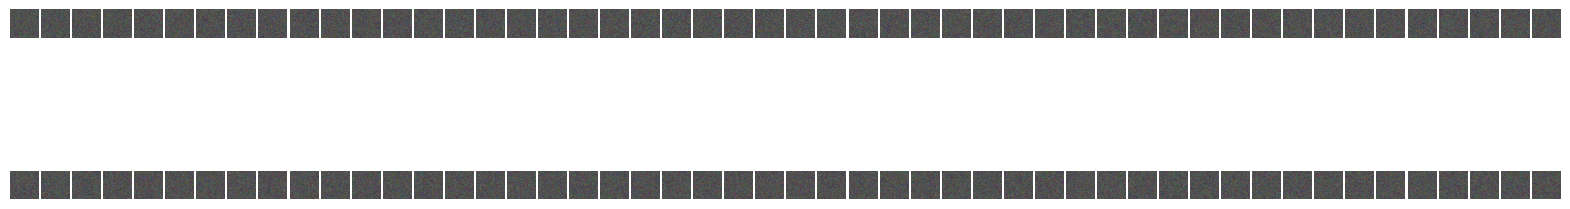

In [ ]:
image_dir = "res_dc_MHist_ConvNet7_50ipc_noise"

image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])

fig, axes = plt.subplots(2, 50, figsize=(20, 4))
fig.subplots_adjust(hspace=0.1, wspace=0.1)


for idx, image_file in enumerate(image_files[:100]):
    # Load the image in RGB
    image_path = os.path.join(image_dir, image_file)
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    row = idx // 50
    col = idx % 50

    axes[row, col].imshow(image_rgb)
    axes[row, col].axis('off')

plt.show()

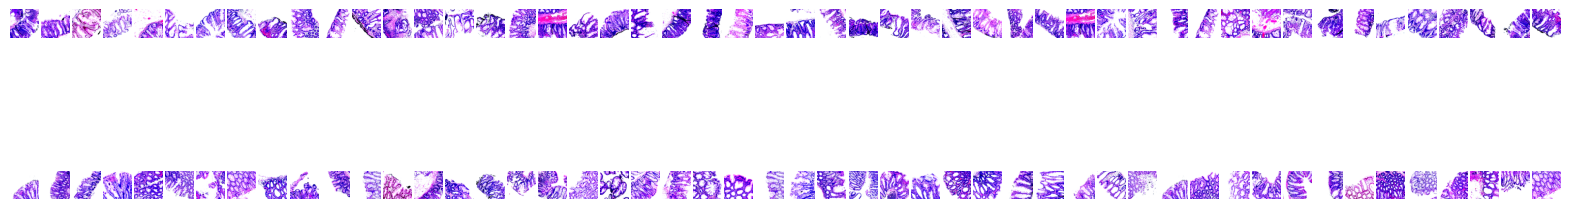

In [ ]:
image_dir = "res_dc_MHist_ConvNet7_50ipc_real"

image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])

fig, axes = plt.subplots(2, 50, figsize=(20, 4))
fig.subplots_adjust(hspace=0.1, wspace=0.1)


for idx, image_file in enumerate(image_files[:100]):
    # Load the image in RGB
    image_path = os.path.join(image_dir, image_file)
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    row = idx // 50
    col = idx % 50

    axes[row, col].imshow(image_rgb)
    axes[row, col].axis('off')

plt.show()

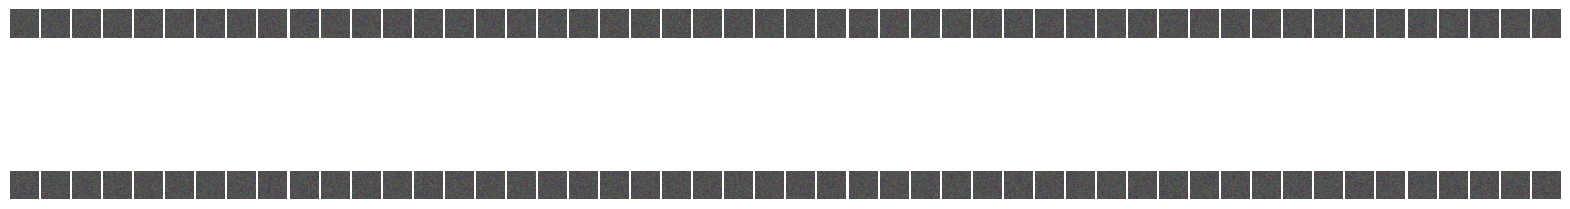

In [ ]:
image_dir = "res_dm_MHist_ConvNet7_50ipc_noise"

image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])

fig, axes = plt.subplots(2, 50, figsize=(20, 4))
fig.subplots_adjust(hspace=0.1, wspace=0.1)


for idx, image_file in enumerate(image_files[:100]):
    # Load the image in RGB
    image_path = os.path.join(image_dir, image_file)
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    row = idx // 50
    col = idx % 50

    axes[row, col].imshow(image_rgb)
    axes[row, col].axis('off')

plt.show()

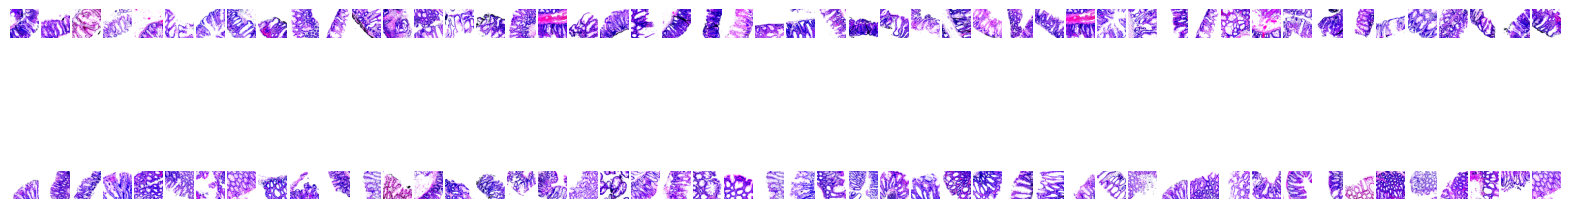

In [ ]:
image_dir = "res_dm_MHist_ConvNet7_50ipc_real"

image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])

fig, axes = plt.subplots(2, 50, figsize=(20, 4))
fig.subplots_adjust(hspace=0.1, wspace=0.1)


for idx, image_file in enumerate(image_files[:100]):
    # Load the image in RGB
    image_path = os.path.join(image_dir, image_file)
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    row = idx // 50
    col = idx % 50

    axes[row, col].imshow(image_rgb)
    axes[row, col].axis('off')

plt.show()

In [21]:
import torchvision.models as models
class VGG16(nn.Module):
    def __init__(self, num_classes=2, num_channels=1):
        super(VGG16, self).__init__()
        self.model = models.vgg16(pretrained=True)

        if num_channels != 3:
            self.model.features[0] = nn.Conv2d(num_channels, 64, kernel_size=3, stride=1, padding=1)

        self.model.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        num_features = self.model.classifier[0].in_features

        self.model.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        return self.model(x)

In [14]:
class ResNet18(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet18, self).__init__()
        # Load pre-trained ResNet-18
        self.model = models.resnet18(pretrained=True)

        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

In [15]:
class ResNet_MNIST(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet_MNIST, self).__init__()
        # Load pre-trained ResNet-18
        self.model = models.resnet18(pretrained=True)

        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

In [ ]:
class MhistImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = os.listdir(image_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])

        image = Image.open(img_path).convert("RGB")

        label = int(self.image_files[idx].split('_')[0])

        if self.transform:
            image = self.transform(image)

        return image, label



---



In [ ]:
# res_dc_MHist_ConvNet7_50ipc_noise
image_dir = "res_dc_MHist_ConvNet7_50ipc_noise"

transform = transforms.Compose([
    transforms.ToTensor(),
])

mhist = MhistImageDataset(image_dir=image_dir, transform=transform)

mhist = DataLoader(mhist, batch_size=16, shuffle=True)

for images, labels in mhist:
    print("Batch of images:", images.shape)
    print("Batch of labels:", labels)
    break

Batch of images: torch.Size([16, 3, 256, 256])
Batch of labels: tensor([1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0])


In [ ]:
mhist_resnet = ResNet18(num_classes=2).to(device)
print("Training ResNet18 on res_dc_MHist_50ipc_noise.\n")
optimizer = torch.optim.SGD(mhist_resnet.parameters(), lr=args.learning_rate)
criterion = nn.CrossEntropyLoss()
scheduler = CosineAnnealingLR(optimizer, T_max=args.scheduler_T_max)

start = time.time()
for epoch in range(args.epochs):
    train_loss, train_acc = utils.epoch('train', mhist, mhist_resnet, optimizer, criterion, args=args, aug=args.dsa)
    print(f"Epoch {epoch+1}/{args.epochs}, Loss: {train_loss:.2f}, Accuracy: {train_acc:.2f}")

    scheduler.step()

end = time.time()
print(f"\nTotal training time: {end - start}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 143MB/s]


Training ResNet18 on res_dc_MHist_50ipc_noise.

Epoch 1/20, Loss: 0.87, Accuracy: 0.49
Epoch 2/20, Loss: 0.85, Accuracy: 0.54
Epoch 3/20, Loss: 0.88, Accuracy: 0.53
Epoch 4/20, Loss: 0.76, Accuracy: 0.60
Epoch 5/20, Loss: 0.56, Accuracy: 0.72
Epoch 6/20, Loss: 0.66, Accuracy: 0.60
Epoch 7/20, Loss: 0.52, Accuracy: 0.72
Epoch 8/20, Loss: 0.45, Accuracy: 0.81
Epoch 9/20, Loss: 0.64, Accuracy: 0.70
Epoch 10/20, Loss: 0.61, Accuracy: 0.68
Epoch 11/20, Loss: 0.62, Accuracy: 0.75
Epoch 12/20, Loss: 0.45, Accuracy: 0.80
Epoch 13/20, Loss: 0.41, Accuracy: 0.82
Epoch 14/20, Loss: 0.66, Accuracy: 0.64
Epoch 15/20, Loss: 0.57, Accuracy: 0.66
Epoch 16/20, Loss: 0.40, Accuracy: 0.87
Epoch 17/20, Loss: 0.56, Accuracy: 0.69
Epoch 18/20, Loss: 0.62, Accuracy: 0.63
Epoch 19/20, Loss: 0.43, Accuracy: 0.80
Epoch 20/20, Loss: 0.48, Accuracy: 0.81

Total training time: 12.638962030410767


In [ ]:
print("Evaluate the ResNet18 on the MHIST test dataset.\n")
test_loss, test_acc = utils.epoch('test', mhist_test_loader, mhist_resnet, optimizer, criterion, args=args, aug=False)
print(f"Test Loss: {train_loss:.2f}, Test Accuracy: {train_acc:.2f}")

Evaluate the ResNet18 on the MHIST test dataset.

Test Loss: 0.48, Test Accuracy: 0.81


In [ ]:
mhist_vgg16 = VGG16(num_classes=2, num_channels=3).to(device)

In [ ]:
print("Training VGG16 on res_dc_MHist_50ipc_noise.\n")
optimizer = torch.optim.SGD(mhist_vgg16.parameters(), lr=args.learning_rate)
criterion = nn.CrossEntropyLoss()
scheduler = CosineAnnealingLR(optimizer, T_max=args.scheduler_T_max)

start = time.time()
for epoch in range(args.epochs):
    train_loss, train_acc = utils.epoch('train', mhist, mhist_vgg16, optimizer, criterion, args=args, aug=args.dsa)
    print(f"Epoch {epoch+1}/{args.epochs}, Loss: {train_loss:.2f}, Accuracy: {train_acc:.2f}")

    scheduler.step()

end = time.time()
print(f"\nTotal training time: {end - start}")

Training VGG16 on res_dc_MHist_50ipc_noise.

Epoch 1/20, Loss: 0.70, Accuracy: 0.47
Epoch 2/20, Loss: 0.69, Accuracy: 0.48
Epoch 3/20, Loss: 0.69, Accuracy: 0.49
Epoch 4/20, Loss: 0.70, Accuracy: 0.43
Epoch 5/20, Loss: 0.70, Accuracy: 0.46
Epoch 6/20, Loss: 0.69, Accuracy: 0.49
Epoch 7/20, Loss: 0.70, Accuracy: 0.46
Epoch 8/20, Loss: 0.69, Accuracy: 0.50
Epoch 9/20, Loss: 0.69, Accuracy: 0.50
Epoch 10/20, Loss: 0.69, Accuracy: 0.51
Epoch 11/20, Loss: 0.70, Accuracy: 0.49
Epoch 12/20, Loss: 0.70, Accuracy: 0.50
Epoch 13/20, Loss: 0.69, Accuracy: 0.51
Epoch 14/20, Loss: 0.70, Accuracy: 0.50
Epoch 15/20, Loss: 0.70, Accuracy: 0.50
Epoch 16/20, Loss: 0.69, Accuracy: 0.49
Epoch 17/20, Loss: 0.69, Accuracy: 0.52
Epoch 18/20, Loss: 0.69, Accuracy: 0.50
Epoch 19/20, Loss: 0.70, Accuracy: 0.50
Epoch 20/20, Loss: 0.70, Accuracy: 0.49

Total training time: 12.747819662094116


In [ ]:
print("Evaluate the VGG16 on the MHIST test dataset.\n")
test_loss, test_acc = utils.epoch('test', mhist_test_loader, mhist_vgg16, optimizer, criterion, args=args, aug=False)
print(f"Test Loss: {train_loss:.2f}, Test Accuracy: {train_acc:.2f}")

Evaluate the VGG16 on the MHIST test dataset.

Test Loss: 0.70, Test Accuracy: 0.49


In [ ]:
# Initialize the ConvNet7 model
channel = 3
num_classes = 2
net_width = 32
net_depth = 7
net_act = 'relu'
net_norm = 'batchnorm'
net_pooling = 'maxpooling'
im_size = (256, 256)

convnet7_mhist = networks.ConvNet(channel, num_classes, net_width, net_depth, net_act, net_norm, net_pooling, im_size).to(device)

In [ ]:
# Train the ConvNet7 model on Mhist dataset
optimizer = torch.optim.SGD(convnet7_mhist.parameters(), lr=args.learning_rate)
criterion = nn.CrossEntropyLoss()
scheduler = CosineAnnealingLR(optimizer, T_max=args.scheduler_T_max)

start = time.time()
for epoch in range(args.epochs):
    train_loss, train_acc = utils.epoch('train', mhist, convnet7_mhist, optimizer, criterion, args=args, aug=args.dsa)
    print(f"Epoch {epoch+1}/{args.epochs}, Loss: {train_loss:.2f}, Accuracy: {train_acc:.2f}")

    scheduler.step()

end = time.time()
print(f"Total training time: {end - start}")

/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch 1/20, Loss: 0.69, Accuracy: 0.57
Epoch 2/20, Loss: 0.64, Accuracy: 0.62
Epoch 3/20, Loss: 0.74, Accuracy: 0.53
Epoch 4/20, Loss: 0.69, Accuracy: 0.59
Epoch 5/20, Loss: 0.71, Accuracy: 0.59
Epoch 6/20, Loss: 0.68, Accuracy: 0.56
Epoch 7/20, Loss: 0.62, Accuracy: 0.62
Epoch 8/20, Loss: 0.56, Accuracy: 0.69
Epoch 9/20, Loss: 0.60, Accuracy: 0.65
Epoch 10/20, Loss: 0.70, Accuracy: 0.55
Epoch 11/20, Loss: 0.54, Accuracy: 0.65
Epoch 12/20, Loss: 0.67, Accuracy: 0.58
Epoch 13/20, Loss: 0.51, Accuracy: 0.73
Epoch 14/20, Loss: 0.61, Accuracy: 0.62
Epoch 15/20, Loss: 0.61, Accuracy: 0.63
Epoch 16/20, Loss: 0.65, Accuracy: 0.60
Epoch 17/20, Loss: 0.53, Accuracy: 0.73
Epoch 18/20, Loss: 0.68, Accuracy: 0.51
Epoch 19/20, Loss: 0.44, Accuracy: 0.83
Epoch 20/20, Loss: 0.50, Accuracy: 0.73
Total training time: 13.340944528579712


In [ ]:
test_loss, test_acc = utils.epoch('test', mhist_test_loader, convnet7_mhist, optimizer, criterion, args=args, aug=False)
print(f"Test Loss: {train_loss:.2f}, Test Accuracy: {train_acc:.2f}")

Test Loss: 0.50, Test Accuracy: 0.73




---



In [ ]:
# res_dm_MHist_ConvNet7_50ipc_noise
image_dir = "res_dm_MHist_ConvNet7_50ipc_noise"

transform = transforms.Compose([
    transforms.ToTensor(),
])

mhist = MhistImageDataset(image_dir=image_dir, transform=transform)

mhist = DataLoader(mhist, batch_size=16, shuffle=True)

for images, labels in mhist:
    print("Batch of images:", images.shape)
    print("Batch of labels:", labels)
    break

Batch of images: torch.Size([16, 3, 256, 256])
Batch of labels: tensor([0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1])


In [ ]:
mhist_resnet = ResNet18(num_classes=2).to(device)
print("Training ResNet18 on res_dm_MHist_50ipc_noise.\n")
optimizer = torch.optim.SGD(mhist_resnet.parameters(), lr=args.learning_rate)
criterion = nn.CrossEntropyLoss()
scheduler = CosineAnnealingLR(optimizer, T_max=args.scheduler_T_max)

start = time.time()
for epoch in range(args.epochs):
    train_loss, train_acc = utils.epoch('train', mhist, mhist_resnet, optimizer, criterion, args=args, aug=args.dsa)
    print(f"Epoch {epoch+1}/{args.epochs}, Loss: {train_loss:.2f}, Accuracy: {train_acc:.2f}")

    scheduler.step()

end = time.time()
print(f"\nTotal training time: {end - start}")

Training ResNet18 on res_dm_MHist_50ipc_noise.

Epoch 1/20, Loss: 0.95, Accuracy: 0.46
Epoch 2/20, Loss: 0.90, Accuracy: 0.50
Epoch 3/20, Loss: 0.77, Accuracy: 0.56
Epoch 4/20, Loss: 0.81, Accuracy: 0.51
Epoch 5/20, Loss: 0.98, Accuracy: 0.44
Epoch 6/20, Loss: 0.54, Accuracy: 0.70
Epoch 7/20, Loss: 0.58, Accuracy: 0.71
Epoch 8/20, Loss: 0.62, Accuracy: 0.66
Epoch 9/20, Loss: 0.53, Accuracy: 0.71
Epoch 10/20, Loss: 0.47, Accuracy: 0.82
Epoch 11/20, Loss: 0.49, Accuracy: 0.68
Epoch 12/20, Loss: 0.33, Accuracy: 0.85
Epoch 13/20, Loss: 0.53, Accuracy: 0.75
Epoch 14/20, Loss: 0.31, Accuracy: 0.87
Epoch 15/20, Loss: 0.50, Accuracy: 0.70
Epoch 16/20, Loss: 0.44, Accuracy: 0.77
Epoch 17/20, Loss: 0.47, Accuracy: 0.78
Epoch 18/20, Loss: 0.56, Accuracy: 0.67
Epoch 19/20, Loss: 0.42, Accuracy: 0.78
Epoch 20/20, Loss: 0.47, Accuracy: 0.82

Total training time: 12.401722431182861


In [ ]:
print("Evaluate the ResNet18 on the MHIST test dataset.\n")
test_loss, test_acc = utils.epoch('test', mhist_test_loader, mhist_resnet, optimizer, criterion, args=args, aug=False)
print(f"Test Loss: {train_loss:.2f}, Test Accuracy: {train_acc:.2f}")

Evaluate the ResNet18 on the MHIST test dataset.

Test Loss: 0.47, Test Accuracy: 0.82


In [ ]:
mhist_vgg16 = VGG16(num_classes=2, num_channels=3).to(device)

In [ ]:
print("Training VGG16 on res_dm_MHist_50ipc_noise.\n")
optimizer = torch.optim.SGD(mhist_vgg16.parameters(), lr=args.learning_rate)
criterion = nn.CrossEntropyLoss()
scheduler = CosineAnnealingLR(optimizer, T_max=args.scheduler_T_max)

start = time.time()
for epoch in range(args.epochs):
    train_loss, train_acc = utils.epoch('train', mhist, mhist_vgg16, optimizer, criterion, args=args, aug=args.dsa)
    print(f"Epoch {epoch+1}/{args.epochs}, Loss: {train_loss:.2f}, Accuracy: {train_acc:.2f}")

    scheduler.step()

end = time.time()
print(f"\nTotal training time: {end - start}")

Training VGG16 on res_dm_MHist_50ipc_noise.

Epoch 1/20, Loss: 0.70, Accuracy: 0.55
Epoch 2/20, Loss: 0.69, Accuracy: 0.50
Epoch 3/20, Loss: 0.69, Accuracy: 0.51
Epoch 4/20, Loss: 0.69, Accuracy: 0.50
Epoch 5/20, Loss: 0.70, Accuracy: 0.50
Epoch 6/20, Loss: 0.69, Accuracy: 0.49
Epoch 7/20, Loss: 0.69, Accuracy: 0.48
Epoch 8/20, Loss: 0.69, Accuracy: 0.52
Epoch 9/20, Loss: 0.69, Accuracy: 0.56
Epoch 10/20, Loss: 0.69, Accuracy: 0.59
Epoch 11/20, Loss: 0.69, Accuracy: 0.50
Epoch 12/20, Loss: 0.69, Accuracy: 0.52
Epoch 13/20, Loss: 0.69, Accuracy: 0.49
Epoch 14/20, Loss: 0.69, Accuracy: 0.53
Epoch 15/20, Loss: 0.69, Accuracy: 0.43
Epoch 16/20, Loss: 0.70, Accuracy: 0.45
Epoch 17/20, Loss: 0.70, Accuracy: 0.43
Epoch 18/20, Loss: 0.69, Accuracy: 0.46
Epoch 19/20, Loss: 0.69, Accuracy: 0.52
Epoch 20/20, Loss: 0.69, Accuracy: 0.50

Total training time: 12.802524089813232


In [ ]:
print("Evaluate the VGG16 on the MHIST test dataset.\n")
test_loss, test_acc = utils.epoch('test', mhist_test_loader, mhist_vgg16, optimizer, criterion, args=args, aug=False)
print(f"Test Loss: {train_loss:.2f}, Test Accuracy: {train_acc:.2f}")

Evaluate the VGG16 on the MHIST test dataset.

Test Loss: 0.69, Test Accuracy: 0.50


In [ ]:
# Initialize the ConvNet7 model
channel = 3
num_classes = 2
net_width = 32
net_depth = 7
net_act = 'relu'
net_norm = 'batchnorm'
net_pooling = 'maxpooling'
im_size = (256, 256)

convnet7_mhist = networks.ConvNet(channel, num_classes, net_width, net_depth, net_act, net_norm, net_pooling, im_size).to(device)

In [ ]:
# Train the ConvNet7 model on Mhist dataset
optimizer = torch.optim.SGD(convnet7_mhist.parameters(), lr=args.learning_rate)
criterion = nn.CrossEntropyLoss()
scheduler = CosineAnnealingLR(optimizer, T_max=args.scheduler_T_max)

start = time.time()
for epoch in range(args.epochs):
    train_loss, train_acc = utils.epoch('train', mhist, convnet7_mhist, optimizer, criterion, args=args, aug=args.dsa)
    print(f"Epoch {epoch+1}/{args.epochs}, Loss: {train_loss:.2f}, Accuracy: {train_acc:.2f}")

    scheduler.step()

end = time.time()
print(f"Total training time: {end - start}")

Epoch 1/20, Loss: 0.75, Accuracy: 0.48
Epoch 2/20, Loss: 0.82, Accuracy: 0.44
Epoch 3/20, Loss: 0.72, Accuracy: 0.50
Epoch 4/20, Loss: 0.64, Accuracy: 0.59
Epoch 5/20, Loss: 0.65, Accuracy: 0.60
Epoch 6/20, Loss: 0.64, Accuracy: 0.58
Epoch 7/20, Loss: 0.71, Accuracy: 0.58
Epoch 8/20, Loss: 0.77, Accuracy: 0.43
Epoch 9/20, Loss: 0.62, Accuracy: 0.60
Epoch 10/20, Loss: 0.62, Accuracy: 0.62
Epoch 11/20, Loss: 0.62, Accuracy: 0.65
Epoch 12/20, Loss: 0.56, Accuracy: 0.69
Epoch 13/20, Loss: 0.60, Accuracy: 0.58
Epoch 14/20, Loss: 0.43, Accuracy: 0.85
Epoch 15/20, Loss: 0.55, Accuracy: 0.71
Epoch 16/20, Loss: 0.44, Accuracy: 0.78
Epoch 17/20, Loss: 0.55, Accuracy: 0.70
Epoch 18/20, Loss: 0.46, Accuracy: 0.73
Epoch 19/20, Loss: 0.50, Accuracy: 0.67
Epoch 20/20, Loss: 0.53, Accuracy: 0.70
Total training time: 11.585503578186035


In [ ]:
test_loss, test_acc = utils.epoch('test', mhist_test_loader, convnet7_mhist, optimizer, criterion, args=args, aug=False)
print(f"Test Loss: {train_loss:.2f}, Test Accuracy: {train_acc:.2f}")

Test Loss: 0.53, Test Accuracy: 0.70




---



In [ ]:
# res_dc_MHist_ConvNet7_50ipc_real
image_dir = "res_dc_MHist_ConvNet7_50ipc_real"

transform = transforms.Compose([
    transforms.ToTensor(),
])

mhist = MhistImageDataset(image_dir=image_dir, transform=transform)

mhist = DataLoader(mhist, batch_size=16, shuffle=True)

for images, labels in mhist:
    print("Batch of images:", images.shape)
    print("Batch of labels:", labels)
    break

Batch of images: torch.Size([16, 3, 256, 256])
Batch of labels: tensor([0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0])


In [ ]:
mhist_resnet = ResNet18(num_classes=2).to(device)
print("Training ResNet18 on res_dc_MHist_50ipc_real.\n")
optimizer = torch.optim.SGD(mhist_resnet.parameters(), lr=args.learning_rate)
criterion = nn.CrossEntropyLoss()
scheduler = CosineAnnealingLR(optimizer, T_max=args.scheduler_T_max)

start = time.time()
for epoch in range(args.epochs):
    train_loss, train_acc = utils.epoch('train', mhist, mhist_resnet, optimizer, criterion, args=args, aug=args.dsa)
    print(f"Epoch {epoch+1}/{args.epochs}, Loss: {train_loss:.2f}, Accuracy: {train_acc:.2f}")

    scheduler.step()

end = time.time()
print(f"\nTotal training time: {end - start}")

Training ResNet18 on res_dc_MHist_50ipc_real.

Epoch 1/20, Loss: 0.71, Accuracy: 0.61
Epoch 2/20, Loss: 0.79, Accuracy: 0.57
Epoch 3/20, Loss: 0.50, Accuracy: 0.75
Epoch 4/20, Loss: 0.49, Accuracy: 0.77
Epoch 5/20, Loss: 0.31, Accuracy: 0.89
Epoch 6/20, Loss: 0.33, Accuracy: 0.82
Epoch 7/20, Loss: 0.30, Accuracy: 0.87
Epoch 8/20, Loss: 0.27, Accuracy: 0.90
Epoch 9/20, Loss: 0.26, Accuracy: 0.93
Epoch 10/20, Loss: 0.17, Accuracy: 0.97
Epoch 11/20, Loss: 0.17, Accuracy: 0.95
Epoch 12/20, Loss: 0.25, Accuracy: 0.88
Epoch 13/20, Loss: 0.17, Accuracy: 0.94
Epoch 14/20, Loss: 0.13, Accuracy: 0.98
Epoch 15/20, Loss: 0.10, Accuracy: 0.98
Epoch 16/20, Loss: 0.09, Accuracy: 0.99
Epoch 17/20, Loss: 0.09, Accuracy: 0.98
Epoch 18/20, Loss: 0.07, Accuracy: 1.00
Epoch 19/20, Loss: 0.10, Accuracy: 0.99
Epoch 20/20, Loss: 0.08, Accuracy: 1.00

Total training time: 10.958265781402588


In [ ]:
print("Evaluate the ResNet18 on the MHIST test dataset.\n")
test_loss, test_acc = utils.epoch('test', mhist_test_loader, mhist_resnet, optimizer, criterion, args=args, aug=False)
print(f"Test Loss: {train_loss:.2f}, Test Accuracy: {train_acc:.2f}")

Evaluate the ResNet18 on the MHIST test dataset.

Test Loss: 0.08, Test Accuracy: 1.00


In [ ]:
mhist_vgg16 = VGG16(num_classes=2, num_channels=3).to(device)

In [ ]:
print("Training VGG16 on res_dc_MHist_50ipc_real.\n")
optimizer = torch.optim.SGD(mhist_vgg16.parameters(), lr=args.learning_rate)
criterion = nn.CrossEntropyLoss()
scheduler = CosineAnnealingLR(optimizer, T_max=args.scheduler_T_max)

start = time.time()
for epoch in range(args.epochs):
    train_loss, train_acc = utils.epoch('train', mhist, mhist_vgg16, optimizer, criterion, args=args, aug=args.dsa)
    print(f"Epoch {epoch+1}/{args.epochs}, Loss: {train_loss:.2f}, Accuracy: {train_acc:.2f}")

    scheduler.step()

end = time.time()
print(f"\nTotal training time: {end - start}")

Training VGG16 on res_dc_MHist_50ipc_real.

Epoch 1/20, Loss: 0.70, Accuracy: 0.43
Epoch 2/20, Loss: 0.69, Accuracy: 0.53
Epoch 3/20, Loss: 0.69, Accuracy: 0.50
Epoch 4/20, Loss: 0.69, Accuracy: 0.47
Epoch 5/20, Loss: 0.69, Accuracy: 0.55
Epoch 6/20, Loss: 0.69, Accuracy: 0.52
Epoch 7/20, Loss: 0.68, Accuracy: 0.61
Epoch 8/20, Loss: 0.68, Accuracy: 0.53
Epoch 9/20, Loss: 0.67, Accuracy: 0.65
Epoch 10/20, Loss: 0.67, Accuracy: 0.64
Epoch 11/20, Loss: 0.67, Accuracy: 0.62
Epoch 12/20, Loss: 0.67, Accuracy: 0.67
Epoch 13/20, Loss: 0.66, Accuracy: 0.64
Epoch 14/20, Loss: 0.65, Accuracy: 0.71
Epoch 15/20, Loss: 0.64, Accuracy: 0.75
Epoch 16/20, Loss: 0.65, Accuracy: 0.71
Epoch 17/20, Loss: 0.64, Accuracy: 0.68
Epoch 18/20, Loss: 0.65, Accuracy: 0.66
Epoch 19/20, Loss: 0.63, Accuracy: 0.76
Epoch 20/20, Loss: 0.63, Accuracy: 0.75

Total training time: 11.531478643417358


In [ ]:
print("Evaluate the VGG16 on the MHIST test dataset.\n")
test_loss, test_acc = utils.epoch('test', mhist_test_loader, mhist_vgg16, optimizer, criterion, args=args, aug=False)
print(f"Test Loss: {train_loss:.2f}, Test Accuracy: {train_acc:.2f}")

Evaluate the VGG16 on the MHIST test dataset.

Test Loss: 0.63, Test Accuracy: 0.75


In [ ]:
# Initialize the ConvNet7 model
channel = 3
num_classes = 2
net_width = 32
net_depth = 7
net_act = 'relu'
net_norm = 'batchnorm'
net_pooling = 'maxpooling'
im_size = (256, 256)

convnet7_mhist = networks.ConvNet(channel, num_classes, net_width, net_depth, net_act, net_norm, net_pooling, im_size).to(device)

In [ ]:
# Train the ConvNet7 model on Mhist dataset
optimizer = torch.optim.SGD(convnet7_mhist.parameters(), lr=args.learning_rate)
criterion = nn.CrossEntropyLoss()
scheduler = CosineAnnealingLR(optimizer, T_max=args.scheduler_T_max)

start = time.time()
for epoch in range(args.epochs):
    train_loss, train_acc = utils.epoch('train', mhist, convnet7_mhist, optimizer, criterion, args=args, aug=args.dsa)
    print(f"Epoch {epoch+1}/{args.epochs}, Loss: {train_loss:.2f}, Accuracy: {train_acc:.2f}")

    scheduler.step()

end = time.time()
print(f"Total training time: {end - start}")

Epoch 1/20, Loss: 0.79, Accuracy: 0.45
Epoch 2/20, Loss: 0.69, Accuracy: 0.56
Epoch 3/20, Loss: 0.71, Accuracy: 0.54
Epoch 4/20, Loss: 0.76, Accuracy: 0.56
Epoch 5/20, Loss: 0.65, Accuracy: 0.60
Epoch 6/20, Loss: 0.62, Accuracy: 0.62
Epoch 7/20, Loss: 0.65, Accuracy: 0.68
Epoch 8/20, Loss: 0.63, Accuracy: 0.64
Epoch 9/20, Loss: 0.57, Accuracy: 0.69
Epoch 10/20, Loss: 0.54, Accuracy: 0.73
Epoch 11/20, Loss: 0.52, Accuracy: 0.78
Epoch 12/20, Loss: 0.55, Accuracy: 0.73
Epoch 13/20, Loss: 0.48, Accuracy: 0.77
Epoch 14/20, Loss: 0.56, Accuracy: 0.73
Epoch 15/20, Loss: 0.49, Accuracy: 0.81
Epoch 16/20, Loss: 0.48, Accuracy: 0.80
Epoch 17/20, Loss: 0.48, Accuracy: 0.80
Epoch 18/20, Loss: 0.47, Accuracy: 0.81
Epoch 19/20, Loss: 0.49, Accuracy: 0.83
Epoch 20/20, Loss: 0.46, Accuracy: 0.84
Total training time: 11.064589977264404


In [ ]:
test_loss, test_acc = utils.epoch('test', mhist_test_loader, convnet7_mhist, optimizer, criterion, args=args, aug=False)
print(f"Test Loss: {train_loss:.2f}, Test Accuracy: {train_acc:.2f}")

Test Loss: 0.46, Test Accuracy: 0.84




---



In [ ]:
# res_dm_MHist_ConvNet7_50ipc_real
image_dir = "res_dm_MHist_ConvNet7_50ipc_real"

transform = transforms.Compose([
    transforms.ToTensor(),
])

mhist = MhistImageDataset(image_dir=image_dir, transform=transform)

mhist = DataLoader(mhist, batch_size=16, shuffle=True)

for images, labels in mhist:
    print("Batch of images:", images.shape)
    print("Batch of labels:", labels)
    break

Batch of images: torch.Size([16, 3, 256, 256])
Batch of labels: tensor([0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0])


In [ ]:
mhist_resnet = ResNet18(num_classes=2).to(device)
print("Training ResNet18 on res_dm_MHist_50ipc_real.\n")
optimizer = torch.optim.SGD(mhist_resnet.parameters(), lr=args.learning_rate)
criterion = nn.CrossEntropyLoss()
scheduler = CosineAnnealingLR(optimizer, T_max=args.scheduler_T_max)

start = time.time()
for epoch in range(args.epochs):
    train_loss, train_acc = utils.epoch('train', mhist, mhist_resnet, optimizer, criterion, args=args, aug=args.dsa)
    print(f"Epoch {epoch+1}/{args.epochs}, Loss: {train_loss:.2f}, Accuracy: {train_acc:.2f}")

    scheduler.step()

end = time.time()
print(f"\nTotal training time: {end - start}")

Training ResNet18 on res_dm_MHist_50ipc_real.

Epoch 1/20, Loss: 0.95, Accuracy: 0.51
Epoch 2/20, Loss: 1.01, Accuracy: 0.55
Epoch 3/20, Loss: 0.65, Accuracy: 0.69
Epoch 4/20, Loss: 0.56, Accuracy: 0.72
Epoch 5/20, Loss: 0.35, Accuracy: 0.88
Epoch 6/20, Loss: 0.43, Accuracy: 0.80
Epoch 7/20, Loss: 0.26, Accuracy: 0.92
Epoch 8/20, Loss: 0.28, Accuracy: 0.91
Epoch 9/20, Loss: 0.26, Accuracy: 0.90
Epoch 10/20, Loss: 0.18, Accuracy: 0.94
Epoch 11/20, Loss: 0.23, Accuracy: 0.93
Epoch 12/20, Loss: 0.20, Accuracy: 0.93
Epoch 13/20, Loss: 0.19, Accuracy: 0.96
Epoch 14/20, Loss: 0.13, Accuracy: 0.99
Epoch 15/20, Loss: 0.09, Accuracy: 0.99
Epoch 16/20, Loss: 0.12, Accuracy: 0.97
Epoch 17/20, Loss: 0.16, Accuracy: 0.95
Epoch 18/20, Loss: 0.11, Accuracy: 0.98
Epoch 19/20, Loss: 0.10, Accuracy: 1.00
Epoch 20/20, Loss: 0.09, Accuracy: 0.99

Total training time: 10.687545776367188


In [ ]:
print("Evaluate the ResNet18 on the MHIST test dataset.\n")
test_loss, test_acc = utils.epoch('test', mhist_test_loader, mhist_resnet, optimizer, criterion, args=args, aug=False)
print(f"Test Loss: {train_loss:.2f}, Test Accuracy: {train_acc:.2f}")

Evaluate the ResNet18 on the MHIST test dataset.

Test Loss: 0.09, Test Accuracy: 0.99


In [ ]:
mhist_vgg16 = VGG16(num_classes=2, num_channels=3).to(device)

In [ ]:
print("Training VGG16 on res_dm_MHist_50ipc_real.\n")
optimizer = torch.optim.SGD(mhist_vgg16.parameters(), lr=args.learning_rate)
criterion = nn.CrossEntropyLoss()
scheduler = CosineAnnealingLR(optimizer, T_max=args.scheduler_T_max)

start = time.time()
for epoch in range(args.epochs):
    train_loss, train_acc = utils.epoch('train', mhist, mhist_vgg16, optimizer, criterion, args=args, aug=args.dsa)
    print(f"Epoch {epoch+1}/{args.epochs}, Loss: {train_loss:.2f}, Accuracy: {train_acc:.2f}")

    scheduler.step()

end = time.time()
print(f"\nTotal training time: {end - start}")

Training VGG16 on res_dm_MHist_50ipc_real.

Epoch 1/20, Loss: 0.70, Accuracy: 0.47
Epoch 2/20, Loss: 0.69, Accuracy: 0.49
Epoch 3/20, Loss: 0.70, Accuracy: 0.48
Epoch 4/20, Loss: 0.69, Accuracy: 0.50
Epoch 5/20, Loss: 0.69, Accuracy: 0.58
Epoch 6/20, Loss: 0.68, Accuracy: 0.60
Epoch 7/20, Loss: 0.68, Accuracy: 0.57
Epoch 8/20, Loss: 0.67, Accuracy: 0.63
Epoch 9/20, Loss: 0.67, Accuracy: 0.69
Epoch 10/20, Loss: 0.68, Accuracy: 0.56
Epoch 11/20, Loss: 0.68, Accuracy: 0.56
Epoch 12/20, Loss: 0.67, Accuracy: 0.70
Epoch 13/20, Loss: 0.66, Accuracy: 0.68
Epoch 14/20, Loss: 0.66, Accuracy: 0.68
Epoch 15/20, Loss: 0.66, Accuracy: 0.73
Epoch 16/20, Loss: 0.66, Accuracy: 0.62
Epoch 17/20, Loss: 0.65, Accuracy: 0.68
Epoch 18/20, Loss: 0.65, Accuracy: 0.70
Epoch 19/20, Loss: 0.64, Accuracy: 0.77
Epoch 20/20, Loss: 0.64, Accuracy: 0.72

Total training time: 11.526178121566772


In [ ]:
print("Evaluate the VGG16 on the MHIST test dataset.\n")
test_loss, test_acc = utils.epoch('test', mhist_test_loader, mhist_vgg16, optimizer, criterion, args=args, aug=False)
print(f"Test Loss: {train_loss:.2f}, Test Accuracy: {train_acc:.2f}")

Evaluate the VGG16 on the MHIST test dataset.

Test Loss: 0.64, Test Accuracy: 0.72


In [ ]:
# Initialize the ConvNet7 model
channel = 3
num_classes = 2
net_width = 32
net_depth = 7
net_act = 'relu'
net_norm = 'batchnorm'
net_pooling = 'maxpooling'
im_size = (256, 256)

convnet7_mhist = networks.ConvNet(channel, num_classes, net_width, net_depth, net_act, net_norm, net_pooling, im_size).to(device)

In [ ]:
# Train the ConvNet7 model on Mhist dataset
optimizer = torch.optim.SGD(convnet7_mhist.parameters(), lr=args.learning_rate)
criterion = nn.CrossEntropyLoss()
scheduler = CosineAnnealingLR(optimizer, T_max=args.scheduler_T_max)

start = time.time()
for epoch in range(args.epochs):
    train_loss, train_acc = utils.epoch('train', mhist, convnet7_mhist, optimizer, criterion, args=args, aug=args.dsa)
    print(f"Epoch {epoch+1}/{args.epochs}, Loss: {train_loss:.2f}, Accuracy: {train_acc:.2f}")

    scheduler.step()

end = time.time()
print(f"Total training time: {end - start}")

Epoch 1/20, Loss: 0.74, Accuracy: 0.57
Epoch 2/20, Loss: 0.76, Accuracy: 0.48
Epoch 3/20, Loss: 0.68, Accuracy: 0.60
Epoch 4/20, Loss: 0.68, Accuracy: 0.58
Epoch 5/20, Loss: 0.72, Accuracy: 0.55
Epoch 6/20, Loss: 0.66, Accuracy: 0.68
Epoch 7/20, Loss: 0.69, Accuracy: 0.59
Epoch 8/20, Loss: 0.67, Accuracy: 0.63
Epoch 9/20, Loss: 0.62, Accuracy: 0.66
Epoch 10/20, Loss: 0.62, Accuracy: 0.68
Epoch 11/20, Loss: 0.51, Accuracy: 0.75
Epoch 12/20, Loss: 0.53, Accuracy: 0.78
Epoch 13/20, Loss: 0.54, Accuracy: 0.68
Epoch 14/20, Loss: 0.50, Accuracy: 0.76
Epoch 15/20, Loss: 0.57, Accuracy: 0.68
Epoch 16/20, Loss: 0.57, Accuracy: 0.71
Epoch 17/20, Loss: 0.49, Accuracy: 0.80
Epoch 18/20, Loss: 0.49, Accuracy: 0.80
Epoch 19/20, Loss: 0.56, Accuracy: 0.70
Epoch 20/20, Loss: 0.47, Accuracy: 0.83
Total training time: 10.154813051223755


In [ ]:
test_loss, test_acc = utils.epoch('test', mhist_test_loader, convnet7_mhist, optimizer, criterion, args=args, aug=False)
print(f"Test Loss: {train_loss:.2f}, Test Accuracy: {train_acc:.2f}")

Test Loss: 0.47, Test Accuracy: 0.83




---



In [24]:
# Transform for MNIST
transform_mnist = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.1307], std=[0.3081])
])

In [25]:
# Load the MNIST dataset
mnist_train_dataset = datasets.MNIST(root='./data', train=True, transform=transform_mnist, download=True)
mnist_test_dataset = datasets.MNIST(root='./data', train=False, transform=transform_mnist)

mnist_train_loader = DataLoader(dataset=mnist_train_dataset, batch_size=64, shuffle=True)
mnist_test_loader = DataLoader(dataset=mnist_test_dataset, batch_size=1000, shuffle=False)

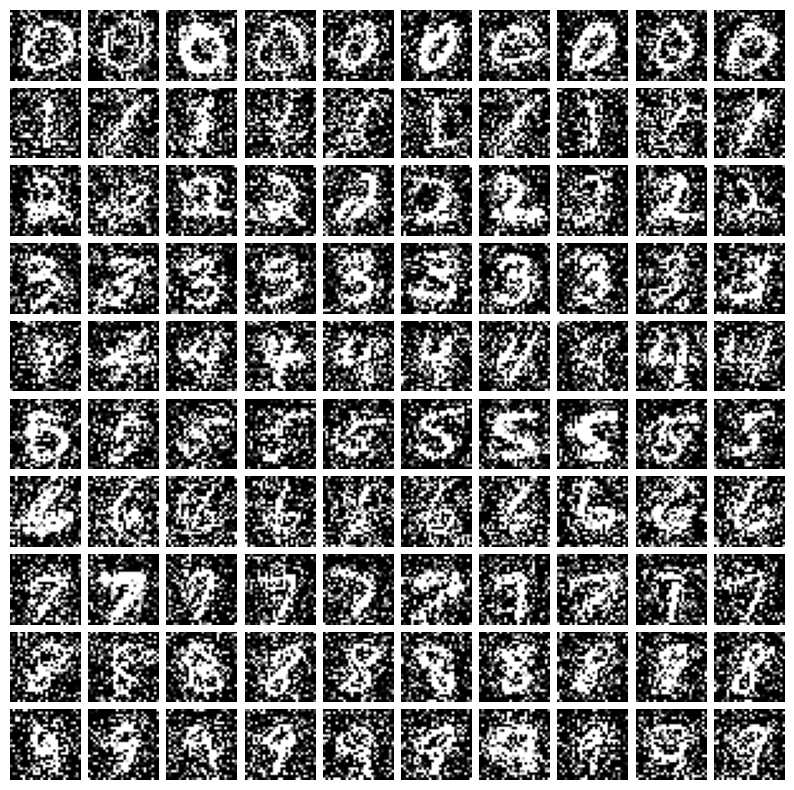

In [ ]:
# res_dm_MNIST_ConvNet3_10ipc_real
image_dir = "res_dm_MNIST_ConvNet3_10ipc_real"

image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])

fig, axes = plt.subplots(10, 10, figsize=(10, 10))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for idx, image_file in enumerate(image_files[:100]):
    # Load the image in grayscale
    image_path = os.path.join(image_dir, image_file)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    row = idx // 10
    col = idx % 10

    axes[row, col].imshow(image, cmap='gray')
    axes[row, col].axis('off')

plt.show()

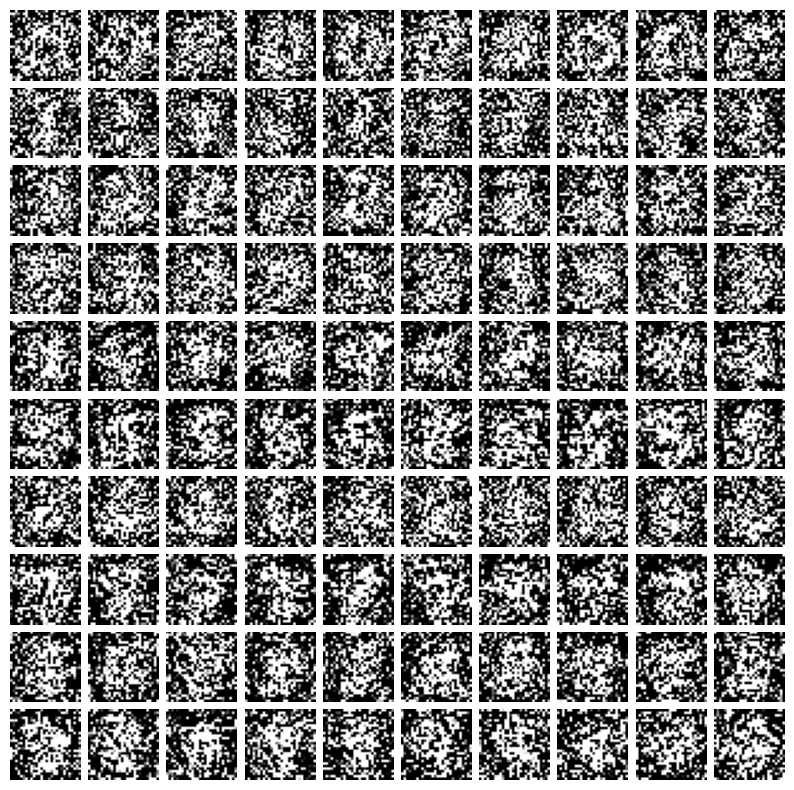

In [ ]:
# res_dm_MNIST_ConvNet3_10ipc_noise
image_dir = "res_dm_MNIST_ConvNet3_10ipc_noise"

image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])

fig, axes = plt.subplots(10, 10, figsize=(10, 10))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for idx, image_file in enumerate(image_files[:100]):
    # Load the image in grayscale
    image_path = os.path.join(image_dir, image_file)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    row = idx // 10
    col = idx % 10

    axes[row, col].imshow(image, cmap='gray')
    axes[row, col].axis('off')

plt.show()

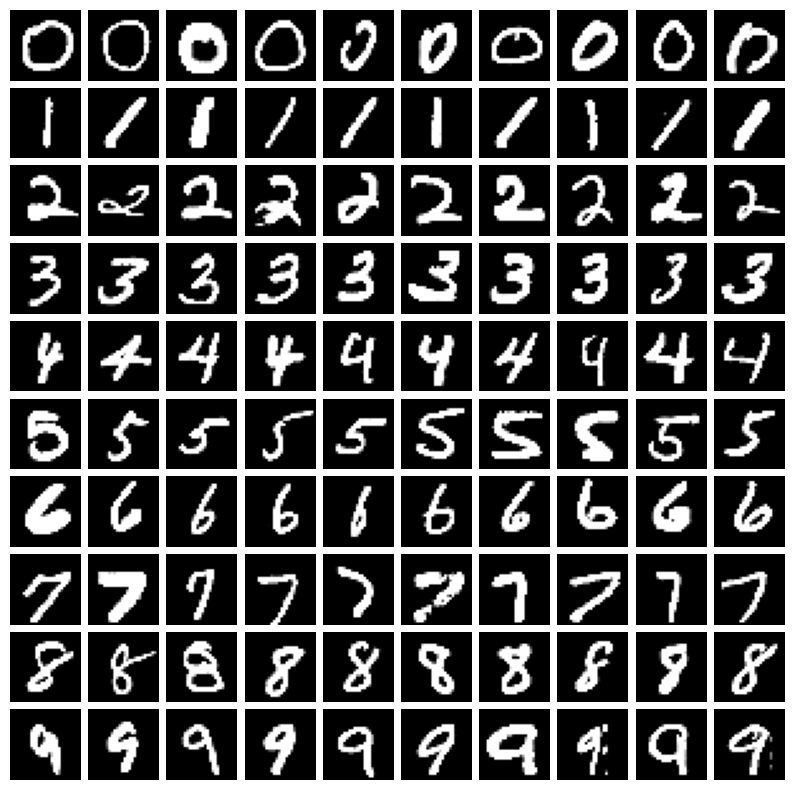

In [ ]:
# res_dc_MNIST_ConvNet3_10ipc_real
image_dir = "res_dc_MNIST_ConvNet3_10ipc_real"

image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])

fig, axes = plt.subplots(10, 10, figsize=(10, 10))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for idx, image_file in enumerate(image_files[:100]):
    # Load the image in grayscale
    image_path = os.path.join(image_dir, image_file)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    row = idx // 10
    col = idx % 10

    axes[row, col].imshow(image, cmap='gray')
    axes[row, col].axis('off')

plt.show()

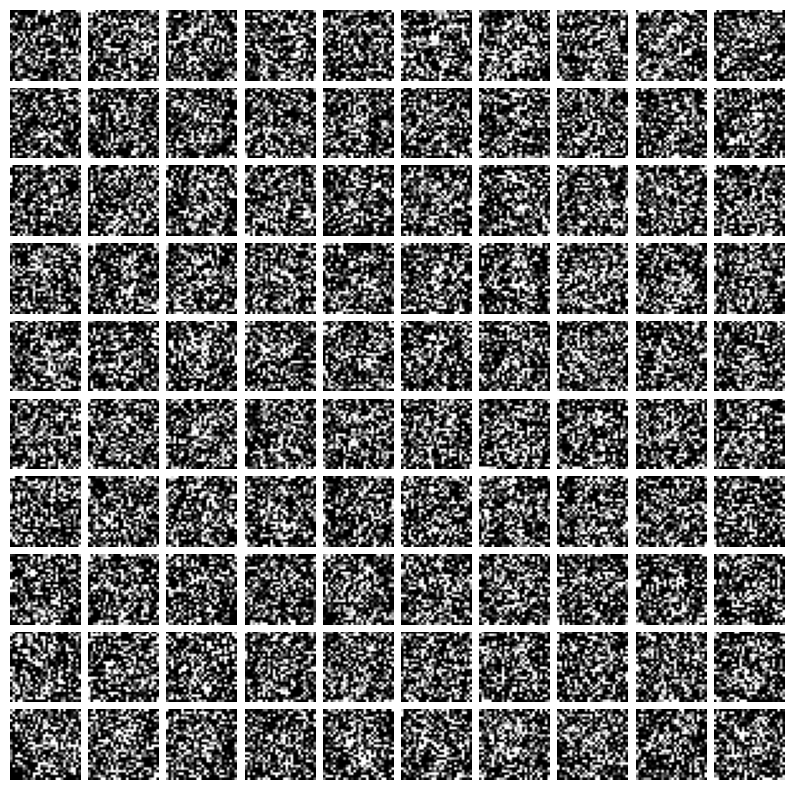

In [ ]:
# res_dc_MNIST_ConvNet3_10ipc_noise
image_dir = "res_dc_MNIST_ConvNet3_10ipc_noise"

image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])

fig, axes = plt.subplots(10, 10, figsize=(10, 10))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for idx, image_file in enumerate(image_files[:100]):
    # Load the image in grayscale
    image_path = os.path.join(image_dir, image_file)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    row = idx // 10
    col = idx % 10

    axes[row, col].imshow(image, cmap='gray')
    axes[row, col].axis('off')

plt.show()

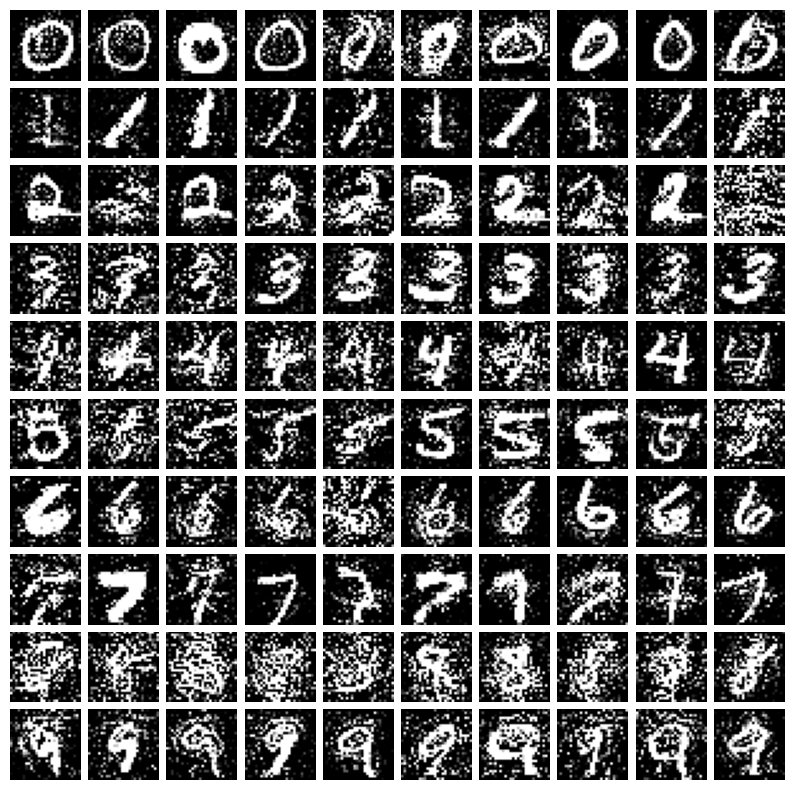

In [ ]:
# res_mtt_MNIST_ConvNet3_10ipc_real
image_dir = "res_mtt_MNIST_ConvNet3_10ipc_real"

image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])

fig, axes = plt.subplots(10, 10, figsize=(10, 10))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for idx, image_file in enumerate(image_files[:100]):
    # Load the image in grayscale
    image_path = os.path.join(image_dir, image_file)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    row = idx // 10
    col = idx % 10

    axes[row, col].imshow(image, cmap='gray')
    axes[row, col].axis('off')

plt.show()

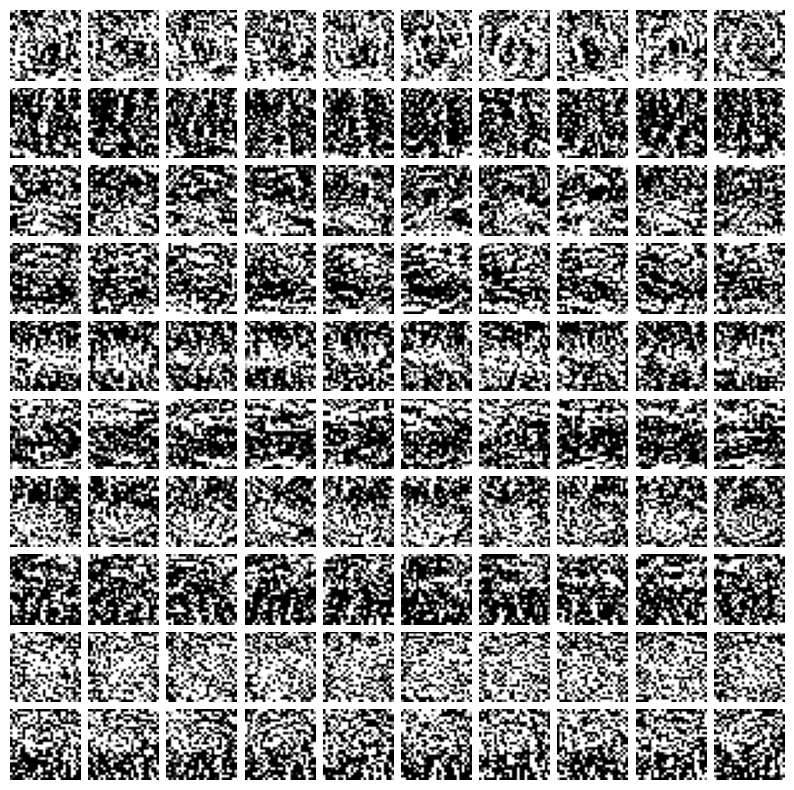

In [ ]:
# res_mtt_MNIST_ConvNet3_10ipc_noise
image_dir = "res_mtt_MNIST_ConvNet3_10ipc_noise"

image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])

fig, axes = plt.subplots(10, 10, figsize=(10, 10))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for idx, image_file in enumerate(image_files[:100]):
    # Load the image in grayscale
    image_path = os.path.join(image_dir, image_file)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    row = idx // 10
    col = idx % 10

    axes[row, col].imshow(image, cmap='gray')
    axes[row, col].axis('off')

plt.show()

In [17]:
# Class for condensed datasets
class CustomImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = os.listdir(image_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])

        image = Image.open(img_path).convert("L")

        label = int(self.image_files[idx].split('_')[0])

        if self.transform:
            image = self.transform(image)

        return image, label



---



In [ ]:
# res_dm_MNIST_ConvNet3_10ipc_real
image_dir = "res_dm_MNIST_ConvNet3_10ipc_real"

transform = transforms.Compose([
    transforms.ToTensor(),
])

mnist = CustomImageDataset(image_dir=image_dir, transform=transform)

mnist = DataLoader(mnist, batch_size=16, shuffle=True)

for images, labels in mnist:
    print("Batch of images:", images.shape)
    print("Batch of labels:", labels)
    break

Batch of images: torch.Size([16, 1, 28, 28])
Batch of labels: tensor([8, 5, 4, 1, 2, 7, 7, 1, 9, 3, 6, 2, 1, 7, 8, 2])


In [ ]:
mnist_resnet = ResNet_MNIST(num_classes=10).to(device)

print("Training ResNet18 on res_dm_MNIST_10ipc_real.\n")
optimizer = torch.optim.SGD(mnist_resnet.parameters(), lr=args.learning_rate)
criterion = nn.CrossEntropyLoss()
scheduler = CosineAnnealingLR(optimizer, T_max=args.scheduler_T_max)

start = time.time()
for epoch in range(args.epochs):
    train_loss, train_acc = utils.epoch('train', mnist, mnist_resnet, optimizer, criterion, args=args, aug=args.dsa)
    print(f"Epoch {epoch+1}/{args.epochs}, Loss: {train_loss:.2f}, Accuracy: {train_acc:.2f}")

    scheduler.step()

end = time.time()
print(f"\nTotal training time: {end - start}")

Training ResNet18 on res_dm_MNIST_10ipc_real.

Epoch 1/20, Loss: 2.62, Accuracy: 0.10
Epoch 2/20, Loss: 2.65, Accuracy: 0.12
Epoch 3/20, Loss: 2.60, Accuracy: 0.14
Epoch 4/20, Loss: 2.57, Accuracy: 0.14
Epoch 5/20, Loss: 2.65, Accuracy: 0.16
Epoch 6/20, Loss: 2.56, Accuracy: 0.14
Epoch 7/20, Loss: 2.31, Accuracy: 0.20
Epoch 8/20, Loss: 2.47, Accuracy: 0.14
Epoch 9/20, Loss: 2.29, Accuracy: 0.18
Epoch 10/20, Loss: 2.27, Accuracy: 0.18
Epoch 11/20, Loss: 2.15, Accuracy: 0.24
Epoch 12/20, Loss: 2.00, Accuracy: 0.28
Epoch 13/20, Loss: 2.12, Accuracy: 0.22
Epoch 14/20, Loss: 1.94, Accuracy: 0.32
Epoch 15/20, Loss: 2.00, Accuracy: 0.30
Epoch 16/20, Loss: 1.91, Accuracy: 0.35
Epoch 17/20, Loss: 1.68, Accuracy: 0.46
Epoch 18/20, Loss: 2.00, Accuracy: 0.29
Epoch 19/20, Loss: 1.88, Accuracy: 0.32
Epoch 20/20, Loss: 1.86, Accuracy: 0.32

Total training time: 5.8118462562561035


In [ ]:
print("Evaluate the ResNet18 on the MNIST test dataset.\n")
test_loss, test_acc = utils.epoch('test', mnist_test_loader, mnist_resnet, optimizer, criterion, args=args, aug=False)
print(f"Test Loss: {train_loss:.2f}, Test Accuracy: {train_acc:.2f}")

Evaluate the ResNet18 on the MNIST test dataset.

Test Loss: 1.86, Test Accuracy: 0.32


In [ ]:
# Initialize the ConvNet3 model
channel = 1
num_classes = 10
net_width = 32
net_depth = 3
net_act = 'relu'
net_norm = 'batchnorm'
net_pooling = 'maxpooling'
im_size = (28, 28)

convnet3_mnist = networks.ConvNet(channel, num_classes, net_width, net_depth, net_act, net_norm, net_pooling, im_size).to(device)

In [ ]:
# Train the ConvNet3 model on condensed mnist images
optimizer = torch.optim.SGD(convnet3_mnist.parameters(), lr=args.learning_rate)
criterion = nn.CrossEntropyLoss()
scheduler = CosineAnnealingLR(optimizer, T_max=args.scheduler_T_max)

start = time.time()
for epoch in range(args.epochs):
    train_loss, train_acc = utils.epoch('train', mnist, convnet3_mnist, optimizer, criterion, args=args, aug=args.dsa)
    print(f"Epoch {epoch+1}/{args.epochs}, Loss: {train_loss:.2f}, Accuracy: {train_acc:.2f}")

    scheduler.step()

end = time.time()
print(f"Total training time: {end - start}")

Epoch 1/20, Loss: 2.46, Accuracy: 0.10
Epoch 2/20, Loss: 2.36, Accuracy: 0.16
Epoch 3/20, Loss: 2.36, Accuracy: 0.13
Epoch 4/20, Loss: 2.22, Accuracy: 0.25
Epoch 5/20, Loss: 2.16, Accuracy: 0.23
Epoch 6/20, Loss: 2.12, Accuracy: 0.24
Epoch 7/20, Loss: 1.97, Accuracy: 0.35
Epoch 8/20, Loss: 1.99, Accuracy: 0.33
Epoch 9/20, Loss: 1.99, Accuracy: 0.37
Epoch 10/20, Loss: 1.83, Accuracy: 0.51
Epoch 11/20, Loss: 1.69, Accuracy: 0.48
Epoch 12/20, Loss: 1.90, Accuracy: 0.40
Epoch 13/20, Loss: 1.77, Accuracy: 0.50
Epoch 14/20, Loss: 1.67, Accuracy: 0.53
Epoch 15/20, Loss: 1.45, Accuracy: 0.75
Epoch 16/20, Loss: 1.47, Accuracy: 0.72
Epoch 17/20, Loss: 1.67, Accuracy: 0.56
Epoch 18/20, Loss: 1.39, Accuracy: 0.79
Epoch 19/20, Loss: 1.35, Accuracy: 0.83
Epoch 20/20, Loss: 1.42, Accuracy: 0.81
Total training time: 4.807323217391968


In [ ]:
test_loss, test_acc = utils.epoch('test', mnist_test_loader, convnet3_mnist, optimizer, criterion, args=args, aug=False)
print(f"Test Loss: {train_loss:.2f}, Test Accuracy: {train_acc:.2f}")

Test Loss: 1.42, Test Accuracy: 0.81




---



In [ ]:
# res_dc_MNIST_ConvNet3_10ipc_real
image_dir = "res_dc_MNIST_ConvNet3_10ipc_real"

transform = transforms.Compose([
    transforms.ToTensor(),
])

mnist = CustomImageDataset(image_dir=image_dir, transform=transform)

mnist = DataLoader(mnist, batch_size=16, shuffle=True)

for images, labels in mnist:
    print("Batch of images:", images.shape)
    print("Batch of labels:", labels)
    break

Batch of images: torch.Size([16, 1, 28, 28])
Batch of labels: tensor([9, 2, 2, 0, 1, 9, 8, 8, 1, 6, 5, 7, 7, 5, 1, 3])


In [ ]:
mnist_resnet = ResNet_MNIST(num_classes=10).to(device)

print("Training ResNet18 on res_dc_MNIST_10ipc_real.\n")
optimizer = torch.optim.SGD(mnist_resnet.parameters(), lr=args.learning_rate)
criterion = nn.CrossEntropyLoss()
scheduler = CosineAnnealingLR(optimizer, T_max=args.scheduler_T_max)

start = time.time()
for epoch in range(args.epochs):
    train_loss, train_acc = utils.epoch('train', mnist, mnist_resnet, optimizer, criterion, args=args, aug=args.dsa)
    print(f"Epoch {epoch+1}/{args.epochs}, Loss: {train_loss:.2f}, Accuracy: {train_acc:.2f}")

    scheduler.step()

end = time.time()
print(f"\nTotal training time: {end - start}")

Training ResNet18 on res_dc_MNIST_10ipc_real.

Epoch 1/20, Loss: 2.56, Accuracy: 0.13
Epoch 2/20, Loss: 2.62, Accuracy: 0.14
Epoch 3/20, Loss: 2.46, Accuracy: 0.21
Epoch 4/20, Loss: 2.36, Accuracy: 0.25
Epoch 5/20, Loss: 2.06, Accuracy: 0.34
Epoch 6/20, Loss: 1.84, Accuracy: 0.38
Epoch 7/20, Loss: 1.93, Accuracy: 0.42
Epoch 8/20, Loss: 2.03, Accuracy: 0.36
Epoch 9/20, Loss: 1.81, Accuracy: 0.43
Epoch 10/20, Loss: 1.75, Accuracy: 0.47
Epoch 11/20, Loss: 1.56, Accuracy: 0.50
Epoch 12/20, Loss: 1.36, Accuracy: 0.53
Epoch 13/20, Loss: 1.65, Accuracy: 0.41
Epoch 14/20, Loss: 1.33, Accuracy: 0.60
Epoch 15/20, Loss: 1.27, Accuracy: 0.57
Epoch 16/20, Loss: 1.25, Accuracy: 0.60
Epoch 17/20, Loss: 1.19, Accuracy: 0.61
Epoch 18/20, Loss: 1.01, Accuracy: 0.68
Epoch 19/20, Loss: 1.04, Accuracy: 0.64
Epoch 20/20, Loss: 0.92, Accuracy: 0.71

Total training time: 5.809547185897827


In [ ]:
print("Evaluate the ResNet18 on the MNIST test dataset.\n")
test_loss, test_acc = utils.epoch('test', mnist_test_loader, mnist_resnet, optimizer, criterion, args=args, aug=False)
print(f"Test Loss: {train_loss:.2f}, Test Accuracy: {train_acc:.2f}")

Evaluate the ResNet18 on the MNIST test dataset.

Test Loss: 0.92, Test Accuracy: 0.71


In [ ]:
# Initialize the ConvNet3 model
channel = 1
num_classes = 10
net_width = 32
net_depth = 3
net_act = 'relu'
net_norm = 'batchnorm'
net_pooling = 'maxpooling'
im_size = (28, 28)

convnet3_mnist = networks.ConvNet(channel, num_classes, net_width, net_depth, net_act, net_norm, net_pooling, im_size).to(device)

In [ ]:
# Train the ConvNet3 model on condensed mnist images
optimizer = torch.optim.SGD(convnet3_mnist.parameters(), lr=args.learning_rate)
criterion = nn.CrossEntropyLoss()
scheduler = CosineAnnealingLR(optimizer, T_max=args.scheduler_T_max)

start = time.time()
for epoch in range(args.epochs):
    train_loss, train_acc = utils.epoch('train', mnist, convnet3_mnist, optimizer, criterion, args=args, aug=args.dsa)
    print(f"Epoch {epoch+1}/{args.epochs}, Loss: {train_loss:.2f}, Accuracy: {train_acc:.2f}")

    scheduler.step()

end = time.time()
print(f"Total training time: {end - start}")

Epoch 1/20, Loss: 2.52, Accuracy: 0.09
Epoch 2/20, Loss: 2.45, Accuracy: 0.11
Epoch 3/20, Loss: 1.97, Accuracy: 0.30
Epoch 4/20, Loss: 1.80, Accuracy: 0.43
Epoch 5/20, Loss: 1.81, Accuracy: 0.35
Epoch 6/20, Loss: 1.53, Accuracy: 0.56
Epoch 7/20, Loss: 1.28, Accuracy: 0.68
Epoch 8/20, Loss: 1.24, Accuracy: 0.72
Epoch 9/20, Loss: 1.12, Accuracy: 0.76
Epoch 10/20, Loss: 1.01, Accuracy: 0.80
Epoch 11/20, Loss: 0.86, Accuracy: 0.91
Epoch 12/20, Loss: 1.11, Accuracy: 0.75
Epoch 13/20, Loss: 0.88, Accuracy: 0.84
Epoch 14/20, Loss: 0.97, Accuracy: 0.79
Epoch 15/20, Loss: 0.73, Accuracy: 0.89
Epoch 16/20, Loss: 0.96, Accuracy: 0.81
Epoch 17/20, Loss: 0.75, Accuracy: 0.88
Epoch 18/20, Loss: 0.85, Accuracy: 0.85
Epoch 19/20, Loss: 0.91, Accuracy: 0.80
Epoch 20/20, Loss: 0.87, Accuracy: 0.82
Total training time: 4.719421148300171


In [ ]:
test_loss, test_acc = utils.epoch('test', mnist_test_loader, convnet3_mnist, optimizer, criterion, args=args, aug=False)
print(f"Test Loss: {train_loss:.2f}, Test Accuracy: {train_acc:.2f}")

Test Loss: 0.87, Test Accuracy: 0.82




---



In [ ]:
# res_dc_MNIST_ConvNet3_10ipc_noise
image_dir = "res_dc_MNIST_ConvNet3_10ipc_noise"

transform = transforms.Compose([
    transforms.ToTensor(),
])

mnist = CustomImageDataset(image_dir=image_dir, transform=transform)

mnist = DataLoader(mnist, batch_size=16, shuffle=True)

for images, labels in mnist:
    print("Batch of images:", images.shape)
    print("Batch of labels:", labels)
    break

Batch of images: torch.Size([16, 1, 28, 28])
Batch of labels: tensor([0, 8, 6, 9, 3, 1, 9, 1, 8, 7, 3, 0, 9, 4, 7, 1])


In [ ]:
mnist_resnet = ResNet_MNIST(num_classes=10).to(device)

print("Training ResNet18 on res_dc_MNIST_10ipc_noise.\n")
optimizer = torch.optim.SGD(mnist_resnet.parameters(), lr=args.learning_rate)
criterion = nn.CrossEntropyLoss()
scheduler = CosineAnnealingLR(optimizer, T_max=args.scheduler_T_max)

start = time.time()
for epoch in range(args.epochs):
    train_loss, train_acc = utils.epoch('train', mnist, mnist_resnet, optimizer, criterion, args=args, aug=args.dsa)
    print(f"Epoch {epoch+1}/{args.epochs}, Loss: {train_loss:.2f}, Accuracy: {train_acc:.2f}")

    scheduler.step()

end = time.time()
print(f"\nTotal training time: {end - start}")

Training ResNet18 on res_dc_MNIST_10ipc_noise.

Epoch 1/20, Loss: 2.67, Accuracy: 0.07
Epoch 2/20, Loss: 2.79, Accuracy: 0.06
Epoch 3/20, Loss: 2.94, Accuracy: 0.11
Epoch 4/20, Loss: 2.75, Accuracy: 0.12
Epoch 5/20, Loss: 2.74, Accuracy: 0.07
Epoch 6/20, Loss: 2.70, Accuracy: 0.12
Epoch 7/20, Loss: 2.54, Accuracy: 0.13
Epoch 8/20, Loss: 2.37, Accuracy: 0.16
Epoch 9/20, Loss: 2.52, Accuracy: 0.17
Epoch 10/20, Loss: 2.44, Accuracy: 0.13
Epoch 11/20, Loss: 2.21, Accuracy: 0.26
Epoch 12/20, Loss: 2.43, Accuracy: 0.13
Epoch 13/20, Loss: 2.21, Accuracy: 0.21
Epoch 14/20, Loss: 2.17, Accuracy: 0.19
Epoch 15/20, Loss: 2.32, Accuracy: 0.18
Epoch 16/20, Loss: 2.23, Accuracy: 0.21
Epoch 17/20, Loss: 2.23, Accuracy: 0.27
Epoch 18/20, Loss: 2.01, Accuracy: 0.32
Epoch 19/20, Loss: 2.21, Accuracy: 0.20
Epoch 20/20, Loss: 2.27, Accuracy: 0.15

Total training time: 5.686805486679077


In [ ]:
print("Evaluate the ResNet18 on the MNIST test dataset.\n")
test_loss, test_acc = utils.epoch('test', mnist_test_loader, mnist_resnet, optimizer, criterion, args=args, aug=False)
print(f"Test Loss: {train_loss:.2f}, Test Accuracy: {train_acc:.2f}")

Evaluate the ResNet18 on the MNIST test dataset.

Test Loss: 2.27, Test Accuracy: 0.15


In [ ]:
# Initialize the ConvNet3 model
channel = 1
num_classes = 10
net_width = 32
net_depth = 3
net_act = 'relu'
net_norm = 'batchnorm'
net_pooling = 'maxpooling'
im_size = (28, 28)

convnet3_mnist = networks.ConvNet(channel, num_classes, net_width, net_depth, net_act, net_norm, net_pooling, im_size).to(device)

In [ ]:
# Train the ConvNet3 model on condensed mnist images
optimizer = torch.optim.SGD(convnet3_mnist.parameters(), lr=args.learning_rate)
criterion = nn.CrossEntropyLoss()
scheduler = CosineAnnealingLR(optimizer, T_max=args.scheduler_T_max)

start = time.time()
for epoch in range(args.epochs):
    train_loss, train_acc = utils.epoch('train', mnist, convnet3_mnist, optimizer, criterion, args=args, aug=args.dsa)
    print(f"Epoch {epoch+1}/{args.epochs}, Loss: {train_loss:.2f}, Accuracy: {train_acc:.2f}")

    scheduler.step()

end = time.time()
print(f"Total training time: {end - start}")

Epoch 1/20, Loss: 2.47, Accuracy: 0.07
Epoch 2/20, Loss: 2.53, Accuracy: 0.12
Epoch 3/20, Loss: 2.35, Accuracy: 0.17
Epoch 4/20, Loss: 2.20, Accuracy: 0.20
Epoch 5/20, Loss: 2.38, Accuracy: 0.18
Epoch 6/20, Loss: 2.20, Accuracy: 0.19
Epoch 7/20, Loss: 2.06, Accuracy: 0.37
Epoch 8/20, Loss: 1.89, Accuracy: 0.42
Epoch 9/20, Loss: 2.08, Accuracy: 0.28
Epoch 10/20, Loss: 1.95, Accuracy: 0.35
Epoch 11/20, Loss: 2.00, Accuracy: 0.31
Epoch 12/20, Loss: 2.01, Accuracy: 0.37
Epoch 13/20, Loss: 1.76, Accuracy: 0.49
Epoch 14/20, Loss: 1.82, Accuracy: 0.51
Epoch 15/20, Loss: 1.63, Accuracy: 0.68
Epoch 16/20, Loss: 1.47, Accuracy: 0.75
Epoch 17/20, Loss: 1.65, Accuracy: 0.60
Epoch 18/20, Loss: 1.61, Accuracy: 0.64
Epoch 19/20, Loss: 1.82, Accuracy: 0.51
Epoch 20/20, Loss: 1.70, Accuracy: 0.64
Total training time: 4.886355400085449


In [ ]:
test_loss, test_acc = utils.epoch('test', mnist_test_loader, convnet3_mnist, optimizer, criterion, args=args, aug=False)
print(f"Test Loss: {train_loss:.2f}, Test Accuracy: {train_acc:.2f}")

Test Loss: 1.70, Test Accuracy: 0.64




---



In [ ]:
# res_dm_MNIST_ConvNet3_10ipc_noise
image_dir = "res_dm_MNIST_ConvNet3_10ipc_noise"

transform = transforms.Compose([
    transforms.ToTensor(),
])

mnist = CustomImageDataset(image_dir=image_dir, transform=transform)

mnist = DataLoader(mnist, batch_size=16, shuffle=True)

for images, labels in mnist:
    print("Batch of images:", images.shape)
    print("Batch of labels:", labels)
    break

Batch of images: torch.Size([16, 1, 28, 28])
Batch of labels: tensor([3, 1, 0, 8, 3, 8, 6, 8, 7, 8, 4, 8, 9, 6, 9, 7])


In [ ]:
mnist_resnet = ResNet_MNIST(num_classes=10).to(device)

print("Training ResNet18 on res_dm_MNIST_10ipc_noise.\n")
optimizer = torch.optim.SGD(mnist_resnet.parameters(), lr=args.learning_rate)
criterion = nn.CrossEntropyLoss()
scheduler = CosineAnnealingLR(optimizer, T_max=args.scheduler_T_max)

start = time.time()
for epoch in range(args.epochs):
    train_loss, train_acc = utils.epoch('train', mnist, mnist_resnet, optimizer, criterion, args=args, aug=args.dsa)
    print(f"Epoch {epoch+1}/{args.epochs}, Loss: {train_loss:.2f}, Accuracy: {train_acc:.2f}")

    scheduler.step()

end = time.time()
print(f"\nTotal training time: {end - start}")

Training ResNet18 on res_dm_MNIST_10ipc_noise.

Epoch 1/20, Loss: 2.68, Accuracy: 0.08
Epoch 2/20, Loss: 2.78, Accuracy: 0.08
Epoch 3/20, Loss: 2.99, Accuracy: 0.11
Epoch 4/20, Loss: 2.42, Accuracy: 0.16
Epoch 5/20, Loss: 2.70, Accuracy: 0.07
Epoch 6/20, Loss: 2.57, Accuracy: 0.22
Epoch 7/20, Loss: 2.33, Accuracy: 0.22
Epoch 8/20, Loss: 2.49, Accuracy: 0.17
Epoch 9/20, Loss: 2.30, Accuracy: 0.26
Epoch 10/20, Loss: 2.26, Accuracy: 0.21
Epoch 11/20, Loss: 2.29, Accuracy: 0.26
Epoch 12/20, Loss: 2.18, Accuracy: 0.16
Epoch 13/20, Loss: 2.50, Accuracy: 0.13
Epoch 14/20, Loss: 1.87, Accuracy: 0.37
Epoch 15/20, Loss: 1.93, Accuracy: 0.41
Epoch 16/20, Loss: 1.99, Accuracy: 0.28
Epoch 17/20, Loss: 1.75, Accuracy: 0.43
Epoch 18/20, Loss: 1.84, Accuracy: 0.39
Epoch 19/20, Loss: 1.99, Accuracy: 0.27
Epoch 20/20, Loss: 1.83, Accuracy: 0.37

Total training time: 5.883859157562256


In [ ]:
print("Evaluate the ResNet18 on the MNIST test dataset.\n")
test_loss, test_acc = utils.epoch('test', mnist_test_loader, mnist_resnet, optimizer, criterion, args=args, aug=False)
print(f"Test Loss: {train_loss:.2f}, Test Accuracy: {train_acc:.2f}")

Evaluate the ResNet18 on the MNIST test dataset.

Test Loss: 1.83, Test Accuracy: 0.37


In [ ]:
# Initialize the ConvNet3 model
channel = 1
num_classes = 10
net_width = 32
net_depth = 3
net_act = 'relu'
net_norm = 'batchnorm'
net_pooling = 'maxpooling'
im_size = (28, 28)

convnet3_mnist = networks.ConvNet(channel, num_classes, net_width, net_depth, net_act, net_norm, net_pooling, im_size).to(device)

In [ ]:
# Train the ConvNet3 model on condensed mnist images
optimizer = torch.optim.SGD(convnet3_mnist.parameters(), lr=args.learning_rate)
criterion = nn.CrossEntropyLoss()
scheduler = CosineAnnealingLR(optimizer, T_max=args.scheduler_T_max)

start = time.time()
for epoch in range(args.epochs):
    train_loss, train_acc = utils.epoch('train', mnist, convnet3_mnist, optimizer, criterion, args=args, aug=args.dsa)
    print(f"Epoch {epoch+1}/{args.epochs}, Loss: {train_loss:.2f}, Accuracy: {train_acc:.2f}")

    scheduler.step()

end = time.time()
print(f"Total training time: {end - start}")

Epoch 1/20, Loss: 2.49, Accuracy: 0.12
Epoch 2/20, Loss: 2.45, Accuracy: 0.09
Epoch 3/20, Loss: 2.33, Accuracy: 0.13
Epoch 4/20, Loss: 2.44, Accuracy: 0.11
Epoch 5/20, Loss: 2.19, Accuracy: 0.14
Epoch 6/20, Loss: 2.13, Accuracy: 0.26
Epoch 7/20, Loss: 2.10, Accuracy: 0.31
Epoch 8/20, Loss: 1.99, Accuracy: 0.36
Epoch 9/20, Loss: 1.94, Accuracy: 0.36
Epoch 10/20, Loss: 1.83, Accuracy: 0.40
Epoch 11/20, Loss: 1.86, Accuracy: 0.46
Epoch 12/20, Loss: 1.99, Accuracy: 0.34
Epoch 13/20, Loss: 1.92, Accuracy: 0.38
Epoch 14/20, Loss: 1.60, Accuracy: 0.59
Epoch 15/20, Loss: 1.60, Accuracy: 0.62
Epoch 16/20, Loss: 1.78, Accuracy: 0.46
Epoch 17/20, Loss: 1.57, Accuracy: 0.68
Epoch 18/20, Loss: 1.68, Accuracy: 0.61
Epoch 19/20, Loss: 1.44, Accuracy: 0.80
Epoch 20/20, Loss: 1.62, Accuracy: 0.68
Total training time: 4.4430413246154785


In [ ]:
test_loss, test_acc = utils.epoch('test', mnist_test_loader, convnet3_mnist, optimizer, criterion, args=args, aug=False)
print(f"Test Loss: {train_loss:.2f}, Test Accuracy: {train_acc:.2f}")

Test Loss: 1.62, Test Accuracy: 0.68




---



In [ ]:
# res_mtt_MNIST_ConvNet3_10ipc_real
image_dir = "res_mtt_MNIST_ConvNet3_10ipc_real"

transform = transforms.Compose([
    transforms.ToTensor(),
])

mnist = CustomImageDataset(image_dir=image_dir, transform=transform)

mnist = DataLoader(mnist, batch_size=16, shuffle=True)

for images, labels in mnist:
    print("Batch of images:", images.shape)
    print("Batch of labels:", labels)
    break

Batch of images: torch.Size([16, 1, 28, 28])
Batch of labels: tensor([1, 2, 0, 0, 5, 6, 8, 4, 1, 2, 8, 1, 9, 9, 0, 4])


In [ ]:
mnist_resnet = ResNet_MNIST(num_classes=10).to(device)

print("Training ResNet18 on res_mtt_MNIST_10ipc_real.\n")
optimizer = torch.optim.SGD(mnist_resnet.parameters(), lr=args.learning_rate)
criterion = nn.CrossEntropyLoss()
scheduler = CosineAnnealingLR(optimizer, T_max=args.scheduler_T_max)

start = time.time()
for epoch in range(args.epochs):
    train_loss, train_acc = utils.epoch('train', mnist, mnist_resnet, optimizer, criterion, args=args, aug=args.dsa)
    print(f"Epoch {epoch+1}/{args.epochs}, Loss: {train_loss:.2f}, Accuracy: {train_acc:.2f}")

    scheduler.step()

end = time.time()
print(f"\nTotal training time: {end - start}")

Training ResNet18 on res_mtt_MNIST_10ipc_real.

Epoch 1/20, Loss: 2.70, Accuracy: 0.10
Epoch 2/20, Loss: 2.59, Accuracy: 0.18
Epoch 3/20, Loss: 2.54, Accuracy: 0.19
Epoch 4/20, Loss: 2.30, Accuracy: 0.25
Epoch 5/20, Loss: 2.57, Accuracy: 0.17
Epoch 6/20, Loss: 2.03, Accuracy: 0.29
Epoch 7/20, Loss: 2.21, Accuracy: 0.25
Epoch 8/20, Loss: 2.13, Accuracy: 0.22
Epoch 9/20, Loss: 2.03, Accuracy: 0.26
Epoch 10/20, Loss: 2.01, Accuracy: 0.34
Epoch 11/20, Loss: 1.62, Accuracy: 0.47
Epoch 12/20, Loss: 1.61, Accuracy: 0.49
Epoch 13/20, Loss: 1.52, Accuracy: 0.44
Epoch 14/20, Loss: 1.53, Accuracy: 0.47
Epoch 15/20, Loss: 1.51, Accuracy: 0.51
Epoch 16/20, Loss: 1.56, Accuracy: 0.47
Epoch 17/20, Loss: 1.37, Accuracy: 0.59
Epoch 18/20, Loss: 1.35, Accuracy: 0.53
Epoch 19/20, Loss: 1.36, Accuracy: 0.56
Epoch 20/20, Loss: 1.44, Accuracy: 0.49

Total training time: 5.946264982223511


In [ ]:
print("Evaluate the ResNet18 on the MNIST test dataset.\n")
test_loss, test_acc = utils.epoch('test', mnist_test_loader, mnist_resnet, optimizer, criterion, args=args, aug=False)
print(f"Test Loss: {train_loss:.2f}, Test Accuracy: {train_acc:.2f}")

Evaluate the ResNet18 on the MNIST test dataset.

Test Loss: 1.44, Test Accuracy: 0.49


In [ ]:
convnet3_mnist = networks.ConvNet(channel, num_classes, net_width, net_depth, net_act, net_norm, net_pooling, im_size).to(device)

In [ ]:
optimizer = torch.optim.SGD(convnet3_mnist.parameters(), lr=args.learning_rate)
criterion = nn.CrossEntropyLoss()
scheduler = CosineAnnealingLR(optimizer, T_max=args.scheduler_T_max)

start = time.time()
for epoch in range(args.epochs):
    train_loss, train_acc = utils.epoch('train', mnist, convnet3_mnist, optimizer, criterion, args=args, aug=args.dsa)
    print(f"Epoch {epoch+1}/{args.epochs}, Loss: {train_loss:.2f}, Accuracy: {train_acc:.2f}")

    scheduler.step()

end = time.time()
print(f"Total training time: {end - start}")

Epoch 1/20, Loss: 2.57, Accuracy: 0.10
Epoch 2/20, Loss: 2.56, Accuracy: 0.08
Epoch 3/20, Loss: 2.23, Accuracy: 0.16
Epoch 4/20, Loss: 2.08, Accuracy: 0.32
Epoch 5/20, Loss: 1.91, Accuracy: 0.43
Epoch 6/20, Loss: 1.83, Accuracy: 0.40
Epoch 7/20, Loss: 1.79, Accuracy: 0.41
Epoch 8/20, Loss: 1.69, Accuracy: 0.46
Epoch 9/20, Loss: 1.53, Accuracy: 0.62
Epoch 10/20, Loss: 1.30, Accuracy: 0.71
Epoch 11/20, Loss: 1.39, Accuracy: 0.63
Epoch 12/20, Loss: 1.59, Accuracy: 0.55
Epoch 13/20, Loss: 1.23, Accuracy: 0.76
Epoch 14/20, Loss: 1.42, Accuracy: 0.74
Epoch 15/20, Loss: 1.14, Accuracy: 0.84
Epoch 16/20, Loss: 1.07, Accuracy: 0.89
Epoch 17/20, Loss: 1.45, Accuracy: 0.61
Epoch 18/20, Loss: 1.21, Accuracy: 0.82
Epoch 19/20, Loss: 1.06, Accuracy: 0.84
Epoch 20/20, Loss: 1.11, Accuracy: 0.83
Total training time: 4.228476285934448


In [ ]:
test_loss, test_acc = utils.epoch('test', mnist_test_loader, convnet3_mnist, optimizer, criterion, args=args, aug=False)
print(f"Test Loss: {train_loss:.2f}, Test Accuracy: {train_acc:.2f}")

Test Loss: 1.11, Test Accuracy: 0.83




---



In [ ]:
# res_mtt_MNIST_ConvNet3_10ipc_noise
image_dir = "res_mtt_MNIST_ConvNet3_10ipc_noise"

transform = transforms.Compose([
    transforms.ToTensor(),
])

mnist = CustomImageDataset(image_dir=image_dir, transform=transform)

mnist = DataLoader(mnist, batch_size=16, shuffle=True)

for images, labels in mnist:
    print("Batch of images:", images.shape)
    print("Batch of labels:", labels)
    break

Batch of images: torch.Size([16, 1, 28, 28])
Batch of labels: tensor([1, 8, 2, 9, 2, 8, 7, 4, 5, 1, 4, 0, 9, 5, 7, 8])


In [ ]:
mnist_resnet = ResNet_MNIST(num_classes=10).to(device)

print("Training ResNet18 on res_mtt_MNIST_10ipc_noise.\n")
optimizer = torch.optim.SGD(mnist_resnet.parameters(), lr=args.learning_rate)
criterion = nn.CrossEntropyLoss()
scheduler = CosineAnnealingLR(optimizer, T_max=args.scheduler_T_max)

start = time.time()
for epoch in range(args.epochs):
    train_loss, train_acc = utils.epoch('train', mnist, mnist_resnet, optimizer, criterion, args=args, aug=args.dsa)
    print(f"Epoch {epoch+1}/{args.epochs}, Loss: {train_loss:.2f}, Accuracy: {train_acc:.2f}")

    scheduler.step()

end = time.time()
print(f"\nTotal training time: {end - start}")

Training ResNet18 on res_mtt_MNIST_10ipc_noise.

Epoch 1/20, Loss: 2.62, Accuracy: 0.10
Epoch 2/20, Loss: 2.83, Accuracy: 0.20
Epoch 3/20, Loss: 2.00, Accuracy: 0.31
Epoch 4/20, Loss: 1.65, Accuracy: 0.48
Epoch 5/20, Loss: 1.37, Accuracy: 0.59
Epoch 6/20, Loss: 1.88, Accuracy: 0.42
Epoch 7/20, Loss: 1.67, Accuracy: 0.45
Epoch 8/20, Loss: 1.41, Accuracy: 0.56
Epoch 9/20, Loss: 1.05, Accuracy: 0.64
Epoch 10/20, Loss: 1.25, Accuracy: 0.67
Epoch 11/20, Loss: 0.90, Accuracy: 0.69
Epoch 12/20, Loss: 1.64, Accuracy: 0.47
Epoch 13/20, Loss: 1.36, Accuracy: 0.59
Epoch 14/20, Loss: 1.17, Accuracy: 0.57
Epoch 15/20, Loss: 0.84, Accuracy: 0.75
Epoch 16/20, Loss: 1.09, Accuracy: 0.70
Epoch 17/20, Loss: 1.36, Accuracy: 0.57
Epoch 18/20, Loss: 1.05, Accuracy: 0.69
Epoch 19/20, Loss: 0.92, Accuracy: 0.70
Epoch 20/20, Loss: 1.14, Accuracy: 0.63

Total training time: 5.647268533706665


In [ ]:
print("Evaluate the ResNet18 on the MNIST test dataset.\n")
test_loss, test_acc = utils.epoch('test', mnist_test_loader, mnist_resnet, optimizer, criterion, args=args, aug=False)
print(f"Test Loss: {train_loss:.2f}, Test Accuracy: {train_acc:.2f}")

Evaluate the ResNet18 on the MNIST test dataset.

Test Loss: 1.14, Test Accuracy: 0.63


In [ ]:
convnet3_mnist = networks.ConvNet(channel, num_classes, net_width, net_depth, net_act, net_norm, net_pooling, im_size).to(device)

In [ ]:
optimizer = torch.optim.SGD(convnet3_mnist.parameters(), lr=args.learning_rate)
criterion = nn.CrossEntropyLoss()
scheduler = CosineAnnealingLR(optimizer, T_max=args.scheduler_T_max)

start = time.time()
for epoch in range(args.epochs):
    train_loss, train_acc = utils.epoch('train', mnist, convnet3_mnist, optimizer, criterion, args=args, aug=args.dsa)
    print(f"Epoch {epoch+1}/{args.epochs}, Loss: {train_loss:.2f}, Accuracy: {train_acc:.2f}")

    scheduler.step()

end = time.time()
print(f"Total training time: {end - start}")

Epoch 1/20, Loss: 2.43, Accuracy: 0.11
Epoch 2/20, Loss: 2.30, Accuracy: 0.19
Epoch 3/20, Loss: 2.03, Accuracy: 0.33
Epoch 4/20, Loss: 1.75, Accuracy: 0.40
Epoch 5/20, Loss: 1.80, Accuracy: 0.45
Epoch 6/20, Loss: 1.67, Accuracy: 0.47
Epoch 7/20, Loss: 1.50, Accuracy: 0.53
Epoch 8/20, Loss: 1.35, Accuracy: 0.64
Epoch 9/20, Loss: 1.22, Accuracy: 0.67
Epoch 10/20, Loss: 1.13, Accuracy: 0.75
Epoch 11/20, Loss: 1.11, Accuracy: 0.72
Epoch 12/20, Loss: 1.15, Accuracy: 0.72
Epoch 13/20, Loss: 1.08, Accuracy: 0.76
Epoch 14/20, Loss: 0.89, Accuracy: 0.86
Epoch 15/20, Loss: 0.90, Accuracy: 0.82
Epoch 16/20, Loss: 0.78, Accuracy: 0.89
Epoch 17/20, Loss: 0.99, Accuracy: 0.78
Epoch 18/20, Loss: 0.79, Accuracy: 0.89
Epoch 19/20, Loss: 0.91, Accuracy: 0.80
Epoch 20/20, Loss: 0.95, Accuracy: 0.79
Total training time: 4.780466556549072


In [ ]:
test_loss, test_acc = utils.epoch('test', mnist_test_loader, convnet3_mnist, optimizer, criterion, args=args, aug=False)
print(f"Test Loss: {train_loss:.2f}, Test Accuracy: {train_acc:.2f}")

Test Loss: 0.95, Test Accuracy: 0.79


**(b) Report your findings in both quantitative and qualitative manners and compare them with the results of Task 1. Discuss your results. Do you think the selected methods outperform the Attention Matching algorithm in terms of test accuracy? Explain the effect of the dataset distillation methods in terms of generalization and recognition abilities.**

**Results**

MHIST DM (Initialized from real images) Accuracy:
*   ConvNet - 7: 0.83
*   VGG16: 0.72
*   ResNet18: 0.99

MHIST DC (Initialized from real images) Accuracy:
*   ConvNet - 7: 0.84
*   VGG16: 0.75
*   ResNet18: 1.00

MHIST DM (Initialized from gaussian noise) Accuracy:
*   ConvNet - 7: 0.70
*   VGG16: 0.50
*   ResNet18: 0.82

MHIST DC (Initialized from gaussian noise) Accuracy:
*   ConvNet - 7: 0.74
*   VGG16: 0.49
*   ResNet18: 0.81

MNIST DM (Initialized from real images) Accuracy:
*   ConvNet - 3: 0.81
*   ResNet18: 0.32

MNIST DC (Initialized from real images) Accuracy:
*   ConvNet - 3: 0.83
*   ResNet18: 0.71

MNIST DM (Initialized from gaussian noise) Accuracy:
*   ConvNet - 3: 0.68
*   ResNet18: 0.37

MNIST DC (Initialized from gaussian noise) Accuracy:
*   ConvNet - 3: 0.64
*   ResNet18: 0.15

MNIST MTT (Initialized from real images) Accuracy:
*   ConvNet - 3: 0.83
*   ResNet18: 0.49

MNIST MTT (Initialized from gaussian noise) Accuracy:
*   ConvNet - 3: 0.79
*   ResNet18: 0.63

**Analysis of Results**

The results highlight notable differences in performance based on the distillation method, initialization strategy (real images vs. Gaussian noise), and the architecture of the network.

**MHIST Dataset**

1. Distillation Method (DM vs. DC):

* DC consistently outperformed DM across architectures, showing that DC (Gradient Matching) may be more effective than DM (Distribution Matching) for the MHIST dataset. DC achieved higher accuracy on both ConvNet-7 and VGG16, and notably, ResNet18 reached perfect accuracy (1.00) with DC and real image initialization.

2. Initialization Strategy

* Real Images vs. Gaussian Noise: Real image initialization led to significantly higher accuracy across all architectures. For example, ResNet18 achieved 1.00 accuracy with DC and real images, while it dropped to 0.81 with Gaussian noise. This suggests that real image initialization preserves essential information that Gaussian noise fails to capture effectively, especially on a more complex dataset like MHIST.

3. Network Architecture
* ResNet18 achieved the highest accuracy across both DC and DM methods, benefiting from its depth and ability to capture complex patterns. VGG16, however, performed the lowest, particularly with Gaussian noise, likely due to its sensitivity to spatial information loss in deeper layers.
* ConvNet-7 performed relatively well, achieving an accuracy of 0.84 with DC and real images, demonstrating that even simpler architectures can achieve high accuracy with the right distillation method and initialization.
* VGG16’s accuracy, while decent with real images, was generally lower than ResNet18 and ConvNet-7. This may be due to VGG16’s depth and its design for high-resolution data, which makes it harder to retain relevant features on smaller input data like MHIST, especially with high condensation.

**MNIST Dataset**

1. Distillation Method (DM, DC, MTT)
* DC and MTT showed improved performance over DM for ConvNet-3, while DC led to the highest accuracy for ResNet18 (0.71) when initialized with real images. This implies that DC may be more robust for MNIST as well, as it allows for better gradient matching in low-dimensional data.
2. Initialization Strategy
* Similar to MHIST, real image initialization consistently outperformed Gaussian noise, particularly for ResNet18. For example, ResNet18’s accuracy dropped from 0.71 with DC and real images to 0.15 with DC and Gaussian noise, indicating that Gaussian noise fails to provide enough structural information for effective training, especially in deeper models.
3. Network Architecture
* ConvNet-3 generally achieved higher accuracy than ResNet18 on the MNIST dataset across all methods. This is likely because MNIST’s simpler, lower-resolution images (28x28) suit ConvNet-3’s shallow architecture, while ResNet18, designed for more complex patterns, struggled with overfitting or insufficient data structure, especially when initialized with Gaussian noise.
* For ResNet18, MTT with real image initialization led to a moderate performance (0.49), better than DM or DC with Gaussian noise, showing that MTT may stabilize training by matching the full training trajectory, though it doesn’t fully overcome the architecture’s complexity.

**Additional Findings**

* Epoch Limitations and Training Pace:
Since all models and datasets were trained with the same method and fixed number of epochs for a fair comparison, some models may not have reached their full potential within this time frame. Certain architectures, particularly deeper ones like ResNet18 and VGG16, displayed slower convergence, with accuracy gradually increasing and loss decreasing at a slower rate. Given additional epochs, these models might achieve higher accuracy.

In conclusion, these results underscore the importance of selecting compatible distillation methods, initialization strategies, and architectures based on the dataset's complexity. For high-dimensional data like MHIST, deeper networks like ResNet18 and VGG16 benefit from DC with real image initialization. For simpler data like MNIST, ConvNet-3 performs effectively with DC and MTT. Gaussian noise generally leads to lower accuracy, particularly for deeper networks like VGG16, which struggle to capture structured information without real image initialization.

## **Prioritize Alignment in Dataset Distillation**

**1. Read the papers and answer the following questions for each of them: (Groups of one and two students must choose one and two papers, respectively, as illustrated above—one student, one paper.)**

**(a) What knowledge gap did your one/two chosen dataset distillation methods fill?**

The PAD method addresses alignment issues in dataset distillation by filtering out irrelevant information, focusing on deep-layer features, and optimizing pruning to improve data relevance. This enhances trajectory matching algorithms, resulting in compact, high-quality distilled datasets that retain essential patterns without unnecessary noise, achieving state-of-the-art distillation performance.

---

**(b) What novelty did they contribute compared to their prior methods?**

This work presents a novel two-step alignment strategy. First, during the information extraction phase, data samples are selected based on the number of images per class (IPC) to compress the dataset effectively. Second, in the information embedding phase, the authors suggest pruning the parameters of shallow network layers.

---


**(c) Explain in full detail the methodologies of your selected methods.**

The proposed methodology consists of two main steps: filtering information extraction and filtering information embedding. The authors introduce an Error L2-Norm score to assess the difficulty of training samples. The training process begins with only the easiest samples, gradually incorporating more challenging ones over time. Once the full set of samples is included, simpler samples are gradually removed to refine learning further.

To tackle misalignment in information embedding, the authors propose masking parameters in shallow layers during matching. The masking ratio is adjusted based on the target instances per class (IPC) to optimize alignment.

---


**(d) Discuss the main advantages and disadvantages of your selected methods. Do you think these methods can concretely distill the original datasets? Do you think your selected methods can analyze and inspect the cases of large-scale datasets like ImageNet [8]? Why?**

The primary advantage of this method is that it enables the distilled dataset to achieve higher accuracy than previous approaches, capturing high-level representations more effectively and minimizing misalignment through filtering strategies. However, a key drawback is the high cost of training expert models, which may limit the applicability of this approach to large-scale datasets like ImageNet.

**2. Apply their methods to the selected architecture in part 2 on one of the MNIST or MHIST datasets.**

**(a) Similar to Task 1, the learning pipeline has two stages: (1) learn the condensed images using the selected method(s); (2) train your network from scratch on the condensed images, then evaluate them on the real testing data. (Make sure the comparison is fair. You can use the default hyperparameter of the paper.)**


For this task, we implemented a two-stage learning pipeline.


1.   Image Condensation: We used the specified dataset distillation methods to condense images at three different levels of compression, setting the condensation depth to 25, 50, and 75. The condensed images were then prepared as training data.
2.   Model Training and Evaluation: We trained two network architectures, ConvNet-3 and ResNet-18, from scratch on the condensed images. After training, we evaluated each model on the real MNIST test data to ensure a fair performance comparison. The models were trained using default hyperparameters from the reference paper, maintaining consistency with prior benchmarks.





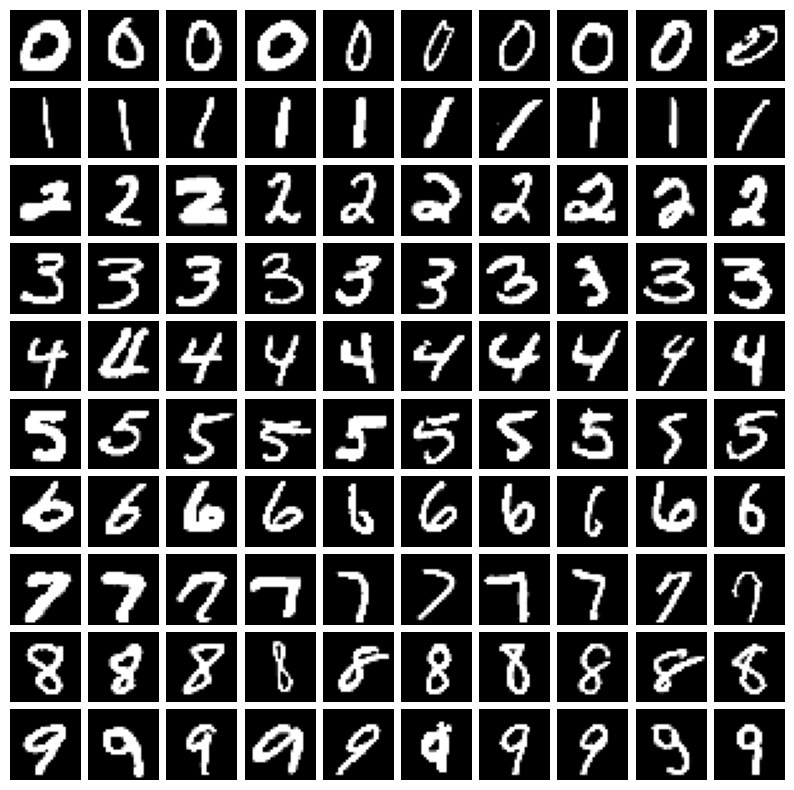

In [ ]:
# MNIST pad with depth = 25
image_dir = "pad_MNIST_25"

image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])

fig, axes = plt.subplots(10, 10, figsize=(10, 10))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for idx, image_file in enumerate(image_files[:100]):
    # Load the image in grayscale
    image_path = os.path.join(image_dir, image_file)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    row = idx // 10
    col = idx % 10

    axes[row, col].imshow(image, cmap='gray')
    axes[row, col].axis('off')

plt.show()

In [29]:
# pad_MNIST_25
image_dir = "pad_MNIST_25"

transform = transforms.Compose([
    transforms.ToTensor(),
])

pad_MNIST_25 = CustomImageDataset(image_dir=image_dir, transform=transform)

pad_MNIST_25 = DataLoader(pad_MNIST_25, batch_size=16, shuffle=True)

for images, labels in pad_MNIST_25:
    print("Batch of images:", images.shape)
    print("Batch of labels:", labels)
    break

Batch of images: torch.Size([16, 1, 28, 28])
Batch of labels: tensor([7, 9, 0, 2, 8, 9, 3, 6, 8, 9, 3, 8, 1, 2, 2, 8])


In [30]:
mnist_resnet = ResNet_MNIST(num_classes=10).to(device)

print("Training ResNet18 on pad_MNIST_25.\n")
optimizer = torch.optim.SGD(mnist_resnet.parameters(), lr=args.learning_rate)
criterion = nn.CrossEntropyLoss()
scheduler = CosineAnnealingLR(optimizer, T_max=args.scheduler_T_max)

start = time.time()
for epoch in range(args.epochs):
    train_loss, train_acc = utils.epoch('train', pad_MNIST_25, mnist_resnet, optimizer, criterion, args=args, aug=args.dsa)
    print(f"Epoch {epoch+1}/{args.epochs}, Loss: {train_loss:.2f}, Accuracy: {train_acc:.2f}")

    scheduler.step()

end = time.time()
print(f"\nTotal training time: {end - start}")

Training ResNet18 on pad_MNIST_25.

Epoch 1/20, Loss: 2.75, Accuracy: 0.07
Epoch 2/20, Loss: 2.65, Accuracy: 0.17
Epoch 3/20, Loss: 2.33, Accuracy: 0.23
Epoch 4/20, Loss: 2.32, Accuracy: 0.21
Epoch 5/20, Loss: 2.07, Accuracy: 0.33
Epoch 6/20, Loss: 2.13, Accuracy: 0.32
Epoch 7/20, Loss: 1.89, Accuracy: 0.39
Epoch 8/20, Loss: 1.81, Accuracy: 0.40
Epoch 9/20, Loss: 1.75, Accuracy: 0.36
Epoch 10/20, Loss: 2.03, Accuracy: 0.33
Epoch 11/20, Loss: 1.68, Accuracy: 0.42
Epoch 12/20, Loss: 1.42, Accuracy: 0.56
Epoch 13/20, Loss: 1.32, Accuracy: 0.55
Epoch 14/20, Loss: 1.43, Accuracy: 0.55
Epoch 15/20, Loss: 1.22, Accuracy: 0.58
Epoch 16/20, Loss: 1.04, Accuracy: 0.65
Epoch 17/20, Loss: 1.33, Accuracy: 0.51
Epoch 18/20, Loss: 1.04, Accuracy: 0.67
Epoch 19/20, Loss: 1.03, Accuracy: 0.65
Epoch 20/20, Loss: 1.00, Accuracy: 0.68

Total training time: 5.486728191375732


In [31]:
print("Evaluate the ResNet18 on the MNIST test dataset.\n")
test_loss, test_acc = utils.epoch('test', mnist_test_loader, mnist_resnet, optimizer, criterion, args=args, aug=False)
print(f"Test Loss: {train_loss:.2f}, Test Accuracy: {train_acc:.2f}")

Evaluate the ResNet18 on the MNIST test dataset.

Test Loss: 1.00, Test Accuracy: 0.68


In [ ]:
convnet3_mnist = networks.ConvNet(channel, num_classes, net_width, net_depth, net_act, net_norm, net_pooling, im_size).to(device)

In [ ]:
# Train the ConvNet3 model on condensed mnist images
optimizer = torch.optim.SGD(convnet3_mnist.parameters(), lr=args.learning_rate)
criterion = nn.CrossEntropyLoss()
scheduler = CosineAnnealingLR(optimizer, T_max=args.scheduler_T_max)

start = time.time()
for epoch in range(args.epochs):
    train_loss, train_acc = utils.epoch('train', pad_MNIST_25, convnet3_mnist, optimizer, criterion, args=args, aug=args.dsa)
    print(f"Epoch {epoch+1}/{args.epochs}, Loss: {train_loss:.2f}, Accuracy: {train_acc:.2f}")

    scheduler.step()

end = time.time()
print(f"Total training time: {end - start}")

Epoch 1/20, Loss: 2.41, Accuracy: 0.10
Epoch 2/20, Loss: 2.34, Accuracy: 0.09
Epoch 3/20, Loss: 2.03, Accuracy: 0.30
Epoch 4/20, Loss: 1.89, Accuracy: 0.39
Epoch 5/20, Loss: 1.80, Accuracy: 0.42
Epoch 6/20, Loss: 1.60, Accuracy: 0.54
Epoch 7/20, Loss: 1.59, Accuracy: 0.52
Epoch 8/20, Loss: 1.47, Accuracy: 0.62
Epoch 9/20, Loss: 1.28, Accuracy: 0.68
Epoch 10/20, Loss: 1.31, Accuracy: 0.65
Epoch 11/20, Loss: 1.15, Accuracy: 0.74
Epoch 12/20, Loss: 1.26, Accuracy: 0.65
Epoch 13/20, Loss: 0.93, Accuracy: 0.86
Epoch 14/20, Loss: 1.26, Accuracy: 0.70
Epoch 15/20, Loss: 1.11, Accuracy: 0.70
Epoch 16/20, Loss: 0.88, Accuracy: 0.84
Epoch 17/20, Loss: 1.07, Accuracy: 0.78
Epoch 18/20, Loss: 1.06, Accuracy: 0.75
Epoch 19/20, Loss: 0.92, Accuracy: 0.83
Epoch 20/20, Loss: 0.99, Accuracy: 0.77
Total training time: 4.892868518829346


In [ ]:
test_loss, test_acc = utils.epoch('test', mnist_test_loader, convnet3_mnist, optimizer, criterion, args=args, aug=False)
print(f"Test Loss: {train_loss:.2f}, Test Accuracy: {train_acc:.2f}")

Test Loss: 0.99, Test Accuracy: 0.77


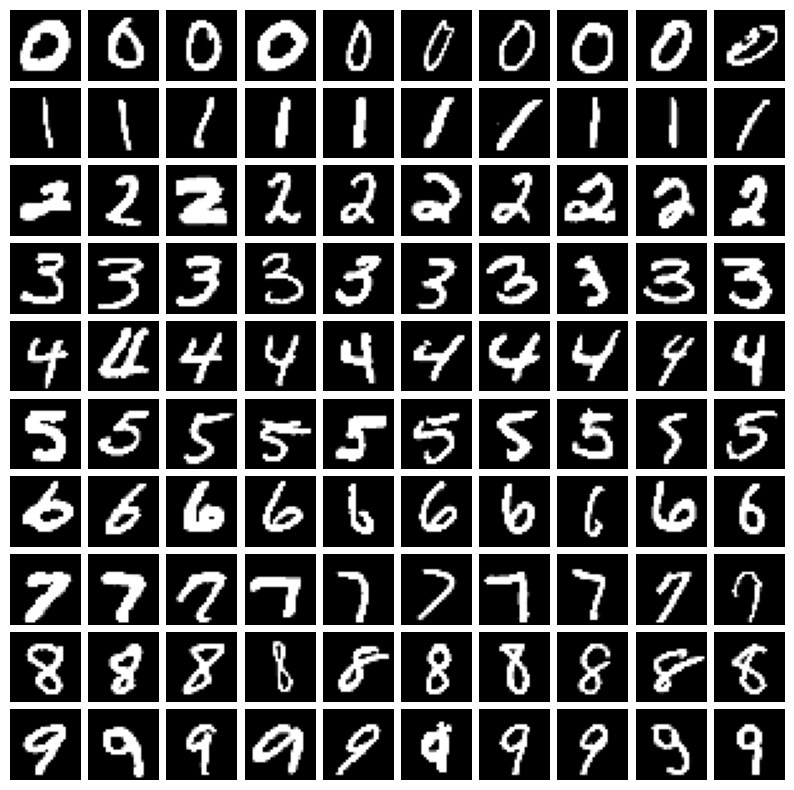

In [ ]:
# MNIST pad with depth = 50
image_dir = "pad_MNIST_50"

image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])

fig, axes = plt.subplots(10, 10, figsize=(10, 10))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for idx, image_file in enumerate(image_files[:100]):
    # Load the image in grayscale
    image_path = os.path.join(image_dir, image_file)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    row = idx // 10
    col = idx % 10

    axes[row, col].imshow(image, cmap='gray')
    axes[row, col].axis('off')

plt.show()

In [19]:
# pad_MNIST_50
image_dir = "pad_MNIST_50"

transform = transforms.Compose([
    transforms.ToTensor(),
])

pad_MNIST_50 = CustomImageDataset(image_dir=image_dir, transform=transform)

pad_MNIST_50 = DataLoader(pad_MNIST_50, batch_size=16, shuffle=True)

for images, labels in pad_MNIST_50:
    print("Batch of images:", images.shape)
    print("Batch of labels:", labels)
    break

Batch of images: torch.Size([16, 1, 28, 28])
Batch of labels: tensor([6, 8, 9, 0, 1, 8, 1, 0, 4, 6, 8, 9, 9, 2, 8, 5])


In [22]:
mnist_resnet = ResNet_MNIST(num_classes=10).to(device)

print("Training ResNet18 on pad_MNIST_50.\n")
optimizer = torch.optim.SGD(mnist_resnet.parameters(), lr=args.learning_rate)
criterion = nn.CrossEntropyLoss()
scheduler = CosineAnnealingLR(optimizer, T_max=args.scheduler_T_max)

start = time.time()
for epoch in range(args.epochs):
    train_loss, train_acc = utils.epoch('train', pad_MNIST_50, mnist_resnet, optimizer, criterion, args=args, aug=args.dsa)
    print(f"Epoch {epoch+1}/{args.epochs}, Loss: {train_loss:.2f}, Accuracy: {train_acc:.2f}")

    scheduler.step()

end = time.time()
print(f"\nTotal training time: {end - start}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 197MB/s]


Training ResNet18 on pad_MNIST_50.



/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch 1/20, Loss: 2.54, Accuracy: 0.12
Epoch 2/20, Loss: 2.54, Accuracy: 0.15
Epoch 3/20, Loss: 2.40, Accuracy: 0.19
Epoch 4/20, Loss: 2.35, Accuracy: 0.24
Epoch 5/20, Loss: 2.36, Accuracy: 0.30
Epoch 6/20, Loss: 2.14, Accuracy: 0.31
Epoch 7/20, Loss: 2.12, Accuracy: 0.34
Epoch 8/20, Loss: 1.93, Accuracy: 0.38
Epoch 9/20, Loss: 1.77, Accuracy: 0.38
Epoch 10/20, Loss: 1.76, Accuracy: 0.39
Epoch 11/20, Loss: 1.70, Accuracy: 0.43
Epoch 12/20, Loss: 1.31, Accuracy: 0.54
Epoch 13/20, Loss: 1.68, Accuracy: 0.44
Epoch 14/20, Loss: 1.40, Accuracy: 0.55
Epoch 15/20, Loss: 1.24, Accuracy: 0.62
Epoch 16/20, Loss: 1.41, Accuracy: 0.55
Epoch 17/20, Loss: 1.17, Accuracy: 0.59
Epoch 18/20, Loss: 1.17, Accuracy: 0.57
Epoch 19/20, Loss: 1.26, Accuracy: 0.59
Epoch 20/20, Loss: 1.28, Accuracy: 0.61

Total training time: 7.3015782833099365


In [26]:
print("Evaluate the ResNet18 on the MNIST test dataset.\n")
test_loss, test_acc = utils.epoch('test', mnist_test_loader, mnist_resnet, optimizer, criterion, args=args, aug=False)
print(f"Test Loss: {train_loss:.2f}, Test Accuracy: {train_acc:.2f}")

Evaluate the ResNet18 on the MNIST test dataset.

Test Loss: 1.28, Test Accuracy: 0.61


In [ ]:
convnet3_mnist = networks.ConvNet(channel, num_classes, net_width, net_depth, net_act, net_norm, net_pooling, im_size).to(device)

In [ ]:
# Train the ConvNet3 model on condensed mnist images
optimizer = torch.optim.SGD(convnet3_mnist.parameters(), lr=args.learning_rate)
criterion = nn.CrossEntropyLoss()
scheduler = CosineAnnealingLR(optimizer, T_max=args.scheduler_T_max)

start = time.time()
for epoch in range(args.epochs):
    train_loss, train_acc = utils.epoch('train', pad_MNIST_50, convnet3_mnist, optimizer, criterion, args=args, aug=args.dsa)
    print(f"Epoch {epoch+1}/{args.epochs}, Loss: {train_loss:.2f}, Accuracy: {train_acc:.2f}")

    scheduler.step()

end = time.time()
print(f"Total training time: {end - start}")

Epoch 1/20, Loss: 2.32, Accuracy: 0.17
Epoch 2/20, Loss: 2.33, Accuracy: 0.11
Epoch 3/20, Loss: 2.09, Accuracy: 0.29
Epoch 4/20, Loss: 1.94, Accuracy: 0.35
Epoch 5/20, Loss: 1.84, Accuracy: 0.47
Epoch 6/20, Loss: 1.75, Accuracy: 0.42
Epoch 7/20, Loss: 1.51, Accuracy: 0.57
Epoch 8/20, Loss: 1.36, Accuracy: 0.68
Epoch 9/20, Loss: 1.53, Accuracy: 0.57
Epoch 10/20, Loss: 1.24, Accuracy: 0.72
Epoch 11/20, Loss: 1.38, Accuracy: 0.58
Epoch 12/20, Loss: 1.17, Accuracy: 0.68
Epoch 13/20, Loss: 1.11, Accuracy: 0.77
Epoch 14/20, Loss: 1.02, Accuracy: 0.84
Epoch 15/20, Loss: 0.99, Accuracy: 0.79
Epoch 16/20, Loss: 1.13, Accuracy: 0.74
Epoch 17/20, Loss: 0.96, Accuracy: 0.83
Epoch 18/20, Loss: 0.97, Accuracy: 0.78
Epoch 19/20, Loss: 1.05, Accuracy: 0.74
Epoch 20/20, Loss: 1.24, Accuracy: 0.67
Total training time: 4.905635833740234


In [ ]:
test_loss, test_acc = utils.epoch('test', mnist_test_loader, convnet3_mnist, optimizer, criterion, args=args, aug=False)
print(f"Test Loss: {train_loss:.2f}, Test Accuracy: {train_acc:.2f}")

Test Loss: 1.24, Test Accuracy: 0.67


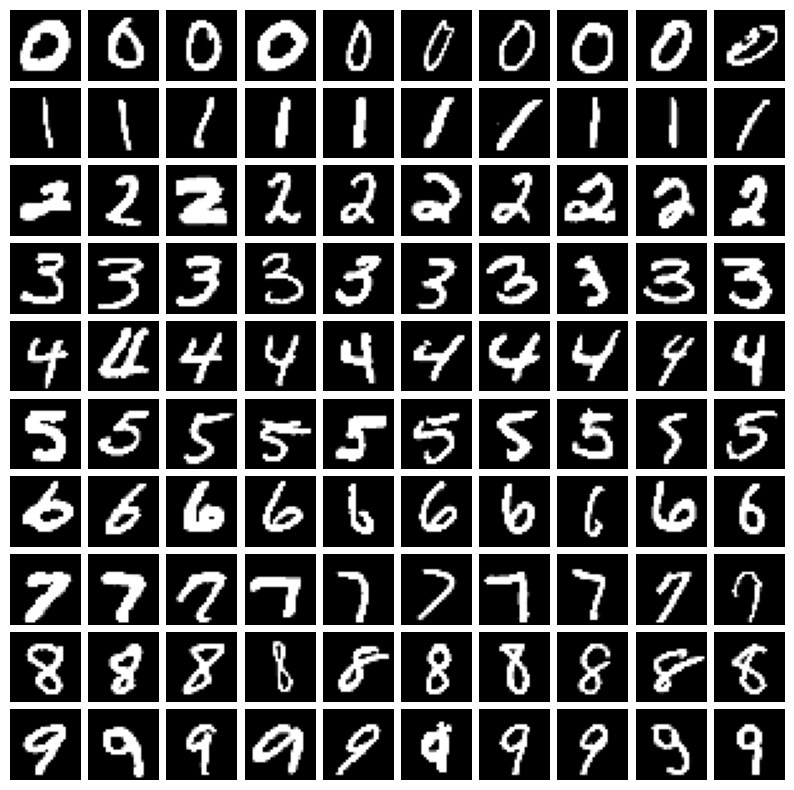

In [ ]:
# MNIST pad with depth = 75
image_dir = "pad_MNIST_75"

image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])

fig, axes = plt.subplots(10, 10, figsize=(10, 10))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for idx, image_file in enumerate(image_files[:100]):
    # Load the image in grayscale
    image_path = os.path.join(image_dir, image_file)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    row = idx // 10
    col = idx % 10

    axes[row, col].imshow(image, cmap='gray')
    axes[row, col].axis('off')

plt.show()

In [32]:
# pad_MNIST_75
image_dir = "pad_MNIST_75"

transform = transforms.Compose([
    transforms.ToTensor(),
])

pad_MNIST_75 = CustomImageDataset(image_dir=image_dir, transform=transform)

pad_MNIST_75 = DataLoader(pad_MNIST_75, batch_size=16, shuffle=True)

for images, labels in pad_MNIST_75:
    print("Batch of images:", images.shape)
    print("Batch of labels:", labels)
    break

Batch of images: torch.Size([16, 1, 28, 28])
Batch of labels: tensor([9, 9, 7, 7, 6, 5, 2, 1, 7, 4, 7, 0, 9, 1, 1, 5])


In [33]:
mnist_resnet = ResNet_MNIST(num_classes=10).to(device)

print("Training ResNet18 on pad_MNIST_75.\n")
optimizer = torch.optim.SGD(mnist_resnet.parameters(), lr=args.learning_rate)
criterion = nn.CrossEntropyLoss()
scheduler = CosineAnnealingLR(optimizer, T_max=args.scheduler_T_max)

start = time.time()
for epoch in range(args.epochs):
    train_loss, train_acc = utils.epoch('train', pad_MNIST_75, mnist_resnet, optimizer, criterion, args=args, aug=args.dsa)
    print(f"Epoch {epoch+1}/{args.epochs}, Loss: {train_loss:.2f}, Accuracy: {train_acc:.2f}")

    scheduler.step()

end = time.time()
print(f"\nTotal training time: {end - start}")

Training ResNet18 on pad_MNIST_75.

Epoch 1/20, Loss: 2.58, Accuracy: 0.15
Epoch 2/20, Loss: 2.42, Accuracy: 0.25
Epoch 3/20, Loss: 2.24, Accuracy: 0.23
Epoch 4/20, Loss: 2.16, Accuracy: 0.32
Epoch 5/20, Loss: 2.38, Accuracy: 0.27
Epoch 6/20, Loss: 2.26, Accuracy: 0.30
Epoch 7/20, Loss: 2.18, Accuracy: 0.29
Epoch 8/20, Loss: 1.87, Accuracy: 0.37
Epoch 9/20, Loss: 1.85, Accuracy: 0.47
Epoch 10/20, Loss: 1.50, Accuracy: 0.49
Epoch 11/20, Loss: 1.59, Accuracy: 0.50
Epoch 12/20, Loss: 1.41, Accuracy: 0.56
Epoch 13/20, Loss: 1.28, Accuracy: 0.56
Epoch 14/20, Loss: 1.18, Accuracy: 0.64
Epoch 15/20, Loss: 1.14, Accuracy: 0.59
Epoch 16/20, Loss: 1.49, Accuracy: 0.51
Epoch 17/20, Loss: 1.42, Accuracy: 0.53
Epoch 18/20, Loss: 1.27, Accuracy: 0.57
Epoch 19/20, Loss: 1.12, Accuracy: 0.62
Epoch 20/20, Loss: 1.28, Accuracy: 0.52

Total training time: 5.46976375579834


In [34]:
print("Evaluate the ResNet18 on the MNIST test dataset.\n")
test_loss, test_acc = utils.epoch('test', mnist_test_loader, mnist_resnet, optimizer, criterion, args=args, aug=False)
print(f"Test Loss: {train_loss:.2f}, Test Accuracy: {train_acc:.2f}")

Evaluate the ResNet18 on the MNIST test dataset.

Test Loss: 1.28, Test Accuracy: 0.52


In [ ]:
convnet3_mnist = networks.ConvNet(channel, num_classes, net_width, net_depth, net_act, net_norm, net_pooling, im_size).to(device)

In [ ]:
# Train the ConvNet3 model on condensed mnist images
optimizer = torch.optim.SGD(convnet3_mnist.parameters(), lr=args.learning_rate)
criterion = nn.CrossEntropyLoss()
scheduler = CosineAnnealingLR(optimizer, T_max=args.scheduler_T_max)

start = time.time()
for epoch in range(args.epochs):
    train_loss, train_acc = utils.epoch('train', pad_MNIST_75, convnet3_mnist, optimizer, criterion, args=args, aug=args.dsa)
    print(f"Epoch {epoch+1}/{args.epochs}, Loss: {train_loss:.2f}, Accuracy: {train_acc:.2f}")

    scheduler.step()

end = time.time()
print(f"Total training time: {end - start}")

Epoch 1/20, Loss: 2.49, Accuracy: 0.08
Epoch 2/20, Loss: 2.23, Accuracy: 0.13
Epoch 3/20, Loss: 2.21, Accuracy: 0.23
Epoch 4/20, Loss: 1.87, Accuracy: 0.38
Epoch 5/20, Loss: 1.72, Accuracy: 0.45
Epoch 6/20, Loss: 1.71, Accuracy: 0.46
Epoch 7/20, Loss: 1.30, Accuracy: 0.68
Epoch 8/20, Loss: 1.44, Accuracy: 0.60
Epoch 9/20, Loss: 1.21, Accuracy: 0.78
Epoch 10/20, Loss: 1.27, Accuracy: 0.71
Epoch 11/20, Loss: 1.03, Accuracy: 0.80
Epoch 12/20, Loss: 0.99, Accuracy: 0.82
Epoch 13/20, Loss: 1.06, Accuracy: 0.73
Epoch 14/20, Loss: 1.18, Accuracy: 0.72
Epoch 15/20, Loss: 1.01, Accuracy: 0.76
Epoch 16/20, Loss: 1.11, Accuracy: 0.72
Epoch 17/20, Loss: 1.12, Accuracy: 0.73
Epoch 18/20, Loss: 1.11, Accuracy: 0.74
Epoch 19/20, Loss: 0.93, Accuracy: 0.74
Epoch 20/20, Loss: 0.93, Accuracy: 0.86
Total training time: 4.800545930862427


In [ ]:
test_loss, test_acc = utils.epoch('test', mnist_test_loader, convnet3_mnist, optimizer, criterion, args=args, aug=False)
print(f"Test Loss: {train_loss:.2f}, Test Accuracy: {train_acc:.2f}")

Test Loss: 0.93, Test Accuracy: 0.86


**(b) Report your findings in both quantitative and qualitative manners and compare them with the results of Task 1. Discuss your results. Do you think the selected methods outperform the Attention Matching algorithm in terms of test accuracy? Explain the effect of the dataset distillation methods in terms of generalization and recognition abilities.**

**Results**

ConvNet-3 Accuracy:

*   Depth 25: 0.77
*   Depth 50: 0.67
*   Depth 75: 0.86

ResNet-18 Accuracy:

*   Depth 25: 0.68
*   Depth 50: 0.61
*   Depth 75: 0.52

**Analysis of Results**

The accuracy is different in model performance based on the depth of condensed data and the network architecture:

*   ConvNet-3 shows a general improvement in accuracy as the condensation depth increases, peaking at 0.86 with depth 75. This suggests that ConvNet-3 is better suited to capture and retain relevant features from higher levels of condensation, potentially due to its simpler architecture, which aligns well with condensed representations.
*   ResNet-18, however, shows a decline in accuracy as the condensation depth increases, with the highest performance (0.68) achieved at depth 25 and a marked drop to 0.52 at depth 75. This decrease may indicate that the deeper ResNet-18 struggles to generalize effectively with heavily condensed data, possibly due to the model’s complexity and tendency to rely on finer-grained features that might be lost in higher condensation levels.

These findings suggest that the optimal condensation depth may vary depending on the architecture. For simpler architectures like ConvNet-3, deeper condensation levels (such as depth 75) enhance performance, while more complex models like ResNet-18 benefit from shallower condensation (depth 25) to retain accuracy. This implies that network simplicity and condensation depth should be carefully balanced for dataset distillation to ensure effective generalization on real test data.

**References**

[1] Dataset distillation,. https://www.tongzhouwang.info/. Available access on 2022 Jun 20.

[2] Towards lossless dataset distillation via difficulty-aligned trajectory matching,. https://
gzyaftermath.github.io/DATM/.

[3] George Cazenavette, Tongzhou Wang, Antonio Torralba, Alexei A Efros, and Jun-Yan Zhu. Dataset distillation by matching training trajectories. In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition, pages 4750–4759, 2022. https://arxiv.org/abs/2203. 11932.

[4] George Cazenavette, Tongzhou Wang, Antonio Torralba, Alexei A Efros, and Jun-Yan Zhu. Gener- alizing dataset distillation via deep generative prior. In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition, pages 3739–3748, 2023.

[5] Dingfan Chen, Raouf Kerkouche, and Mario Fritz. Private set generation with discriminative infor- mation. arXiv preprint arXiv:2211.04446, 2022. https://arxiv.org/pdf/2211.04446.pdf.

[6] Justin Cui, Ruochen Wang, Si Si, and Cho-Jui Hsieh. Dc-bench: Dataset condensation benchmark. arXiv preprint arXiv:2207.09639, 2022. https://openreview.net/pdf?id=Bs8iFQ7AM6.

[7] Justin Cui, Ruochen Wang, Si Si, and Cho-Jui Hsieh. Scaling up dataset distillation to imagenet-1k with constant memory. In International Conference on Machine Learning, pages 6565–6590. PMLR, 2023.

[8] Jia Deng, Wei Dong, Richard Socher, Li-Jia Li, Kai Li, and Li Fei-Fei. Imagenet: A large-scale hierarchical image database. In 2009 IEEE conference on computer vision and pattern recognition, pages 248–255. Ieee, 2009. https://ieeexplore.ieee.org/document/5206848.

[9] Zhiwei Deng and Olga Russakovsky. Remember the past: Distilling datasets into addressable mem- ories for neural networks. arXiv preprint arXiv:2206.02916, 2022. https://arxiv.org/abs/2206. 02916.

[10] Tian Dong, Bo Zhao, and Lingjuan Lyu. Privacy for free: How does dataset condensation help pri- vacy? arXiv preprint arXiv:2206.00240, 2022. https://proceedings.mlr.press/v162/dong22c/ dong22c.pdf.

[11] Spyros Gidaris and Nikos Komodakis. Dynamic few-shot visual learning without forgetting. In Proceedings of the IEEE conference on computer vision and pattern recognition, pages 4367–4375, 2018. https://arxiv.org/abs/1804.09458.

[12] Jack Goetz and Ambuj Tewari. Federated learning via synthetic data. arXiv preprint arXiv:2008.04489, 2020. https://arxiv.org/abs/2008.04489.

[13] Ziyao Guo, Kai Wang, George Cazenavette, Hui Li, Kaipeng Zhang, and Yang You. Towards lossless dataset distillation via difficulty-aligned trajectory matching. arXiv preprint arXiv:2310.05773, 2023.

[14] Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun. Deep residual learning for image recog- nition. In Proceedings of the IEEE conference on computer vision and pattern recognition, pages 770–778, 2016. https://arxiv.org/abs/1512.03385.

[15] Geoffrey Hinton, Oriol Vinyals, Jeff Dean, et al. Distilling the knowledge in a neural network. arXiv preprint arXiv:1503.02531, 2(7), 2015. https://arxiv.org/abs/1503.02531.

[16] Shengyuan Hu, Jack Goetz, Kshitiz Malik, Hongyuan Zhan, Zhe Liu, and Yue Liu. Fedsynth: Gradient compression via synthetic data in federated learning. arXiv preprint arXiv:2204.01273, 2022. https://arxiv.org/pdf/2204.01273.pdf.

[17] Zixuan Jiang, Jiaqi Gu, Mingjie Liu, and David Z Pan. Delving into effective gradient matching for dataset condensation. arXiv preprint arXiv:2208.00311, 2022. https://arxiv.org/abs/2208. 00311.

[18] Wei Jin, Xianfeng Tang, Haoming Jiang, Zheng Li, Danqing Zhang, Jiliang Tang, and Bing Yin. Condensing graphs via one-step gradient matching. In Proceedings of the 28th ACM SIGKDD Conference on Knowledge Discovery and Data Mining, pages 720–730, 2022. https://arxiv.org/ abs/2206.07746.

[19] Wei Jin, Lingxiao Zhao, Shichang Zhang, Yozen Liu, Jiliang Tang, and Neil Shah. Graph condensa- tion for graph neural networks. arXiv preprint arXiv:2110.07580, 2021. https://arxiv.org/pdf/ 2110.07580.pdf.

[20] Balhae Kim, Jungwon Choi, Seanie Lee, Yoonho Lee, Jung-Woo Ha, and Juho Lee. On divergence measures for bayesian pseudocoresets. arXiv preprint arXiv:2210.06205, 2022. https://arxiv. org/abs/2210.06205.

[21] Jang-Hyun Kim, Jinuk Kim, Seong Joon Oh, Sangdoo Yun, Hwanjun Song, Joonhyun Jeong, Jung- Woo Ha, and Hyun Oh Song. Dataset condensation via efficient synthetic-data parameterization. arXiv preprint arXiv:2205.14959, 2022. https://proceedings.mlr.press/v162/kim22c.html.

[22] Alex Krizhevsky, Geoffrey Hinton, et al. Learning multiple layers of features from tiny images. 2009. https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf.

[23] Yann LeCun, L ́eon Bottou, Yoshua Bengio, and Patrick Haffner. Gradient-based learning ap- plied to document recognition. Proceedings of the IEEE, 86(11):2278–2324, 1998. http://vision. stanford.edu/cs598_spring07/papers/Lecun98.pdf.

[24] Saehyung Lee, Sanghyuk Chun, Sangwon Jung, Sangdoo Yun, and Sungroh Yoon. Dataset conden- sation with contrastive signals. arXiv preprint arXiv:2202.02916, 2022. https://arxiv.org/abs/ 2202.02916.

[25] Guang Li, Ren Togo, Takahiro Ogawa, and Miki Haseyama. Soft-label anonymous gastric x-ray image distillation. In 2020 IEEE International Conference on Image Processing (ICIP), pages 305– 309. IEEE, 2020. https://ieeexplore.ieee.org/document/9191357.

[26] Guang Li, Ren Togo, Takahiro Ogawa, and Miki Haseyama. Dataset distillation using parameter pruning. arXiv preprint arXiv:2209.14609, 2022. https://arxiv.org/abs/2209.14609.

[27] Zekai Li, Ziyao Guo, Wangbo Zhao, Tianle Zhang, Zhi-Qi Cheng, Samir Khaki, Kaipeng Zhang, Ahmad Sajedi, Konstantinos N Plataniotis, Kai Wang, and Yang You. Prioritize alignment in dataset distillation, 2024.

[28] Ping Liu, Xin Yu, and Joey Tianyi Zhou. Meta knowledge condensation for federated learning. arXiv preprint arXiv:2209.14851, 2022. https://arxiv.org/pdf/2209.14851.pdf.

[29] Songhua Liu, Kai Wang, Xingyi Yang, Jingwen Ye, and Xinchao Wang. Dataset distillation via factorization. arXiv preprint arXiv:2210.16774, 2022. https://arxiv.org/abs/2210.16774.

[30] Noel Loo, Ramin Hasani, Alexander Amini, and Daniela Rus. Efficient dataset distillation using random feature approximation. arXiv preprint arXiv:2210.12067, 2022. https://openreview.net/ forum?id=h8Bd7Gm3muB.

[31] Jonathan Lorraine, Paul Vicol, and David Duvenaud. Optimizing millions of hyperparameters by implicit differentiation. In International Conference on Artificial Intelligence and Statistics, pages 1540–1552. PMLR, 2020. https://arxiv.org/abs/1911.02590.

[32] Wojciech Masarczyk and Ivona Tautkute. Reducing catastrophic forgetting with learning on syn- thetic data. In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recog- nition Workshops, pages 252–253, 2020. https://arxiv.org/abs/2004.14046.

[33] Timothy Nguyen, Zhourong Chen, and Jaehoon Lee. Dataset meta-learning from kernel ridge- regression. arXiv preprint arXiv:2011.00050, 2020. https://arxiv.org/abs/2011.00050.

[34] Timothy Nguyen, Roman Novak, Lechao Xiao, and Jaehoon Lee. Dataset distillation with infinitely wide convolutional networks. Advances in Neural Information Processing Systems, 34:5186–5198, 2021. https://arxiv.org/abs/2107.13034.

[35] Parsa Nooralinejad, Ali Abbasi, Soheil Kolouri, and Hamed Pirsiavash. Pranc: Pseudo random networks for compacting deep models. arXiv preprint arXiv:2206.08464, 2022. https://arxiv. org/abs/2206.08464.

[36] Ahmad Sajedi, Samir Khaki, Ehsan Amjadian, Lucy Z Liu, Yuri A Lawryshyn, and Konstantinos N Plataniotis. Datadam: Efficient dataset distillation with attention matching. In Proceedings of the IEEE/CVF International Conference on Computer Vision, pages 17097–17107, 2023.

[37] Mattia Sangermano, Antonio Carta, Andrea Cossu, and Davide Bacciu. Sample condensation in online continual learning. In 2022 International Joint Conference on Neural Networks (IJCNN), pages 01–08. IEEE, 2022. https://ieeexplore.ieee.org/document/9892299.

[38] Karen Simonyan and Andrew Zisserman. Very deep convolutional networks for large-scale image recognition. arXiv preprint arXiv:1409.1556, 2014. https://arxiv.org/abs/1409.1556.

[39] Rui Song, Dai Liu, Dave Zhenyu Chen, Andreas Festag, Carsten Trinitis, Martin Schulz, and Alois Knoll. Federated learning via decentralized dataset distillation in resource-constrained edge envi- ronments. arXiv preprint arXiv:2208.11311, 2022. https://arxiv.org/pdf/2208.11311.pdf.

[40] Felipe Petroski Such, Aditya Rawal, Joel Lehman, Kenneth Stanley, and Jeffrey Clune. Generative teaching networks: Accelerating neural architecture search by learning to generate synthetic training data. In International Conference on Machine Learning, pages 9206–9216. PMLR, 2020. http: //proceedings.mlr.press/v119/such20a/such20a.pdf.

[41] Ilia Sucholutsky and Matthias Schonlau. Secdd: Efficient and secure method for remotely training neural networks. arXiv preprint arXiv:2009.09155, 2020. https://arxiv.org/pdf/2009.09155. pdf.

[42] Paul Vicol, Jonathan P Lorraine, Fabian Pedregosa, David Duvenaud, and Roger B Grosse. On implicit bias in overparameterized bilevel optimization. In International Conference on Machine Learning, pages 22234–22259. PMLR, 2022. https://proceedings.mlr.press/v162/vicol22a. html.

[43] Kai Wang, Bo Zhao, Xiangyu Peng, Zheng Zhu, Shuo Yang, Shuo Wang, Guan Huang, Hakan Bilen, Xinchao Wang, and Yang You. Cafe: Learning to condense dataset by aligning features. In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition, pages 12196–12205, 2022. https://arxiv.org/abs/2203.01531.

[44] Tongzhou Wang, Jun-Yan Zhu, Antonio Torralba, and Alexei A Efros. Dataset distillation. arXiv preprint arXiv:1811.10959, 2018. https://arxiv.org/abs/1811.10959.

[45] Jerry Wei, Arief Suriawinata, Bing Ren, Xiaoying Liu, Mikhail Lisovsky, Louis Vaickus, Charles Brown, Michael Baker, Naofumi Tomita, Lorenzo Torresani, et al. A petri dish for histopathology image analysis. In International Conference on Artificial Intelligence in Medicine, pages 11–24. Springer, 2021. https://arxiv.org/abs/2101.12355.

[46] Felix Wiewel and Bin Yang. Condensed composite memory continual learning. In 2021 International Joint Conference on Neural Networks (IJCNN), pages 1–8. IEEE, 2021. https://ieeexplore. ieee.org/document/9533491.

[47] Yuanhao Xiong, Ruochen Wang, Minhao Cheng, Felix Yu, and Cho-Jui Hsieh. Feddm: Iterative dis- tribution matching for communication-efficient federated learning. arXiv preprint arXiv:2207.09653, 2022. https://arxiv.org/abs/2207.09653.

[48] Bo Zhao and Hakan Bilen. Dataset condensation with differentiable siamese augmentation. In International Conference on Machine Learning, pages 12674–12685. PMLR, 2021. https://arxiv. org/abs/2102.08259.

[49] Bo Zhao and Hakan Bilen. Dataset condensation with distribution matching. arXiv preprint arXiv:2110.04181, 2021. https://arxiv.org/abs/2110.04181.

[50] Bo Zhao and Hakan Bilen. Synthesizing informative training samples with gan. arXiv preprint arXiv:2204.07513, 2022. https://arxiv.org/abs/2204.07513.

[51] Bo Zhao, Konda Reddy Mopuri, and Hakan Bilen. Dataset condensation with gradient matching. ICLR, 1(2):3, 2021. https://arxiv.org/abs/2006.05929.

[52] Yanlin Zhou, George Pu, Xiyao Ma, Xiaolin Li, and Dapeng Wu. Distilled one-shot federated learning. arXiv preprint arXiv:2009.07999, 2020. https://arxiv.org/pdf/2009.07999.pdf.

[53] Yongchao Zhou, Ehsan Nezhadarya, and Jimmy Ba. Dataset distillation using neural feature re- gression. arXiv preprint arXiv:2206.00719, 2022. https://arxiv.org/abs/2206.00719.

[54] Yongchao Zhou, Ehsan Nezhadarya, and Jimmy Ba. Dataset distillation using neural feature re- gression. In Advances in Neural Information Processing Systems, 2022.